# Control

## imports

In [1]:
# general imports
import numpy as np
import pandas as pd
from tqdm import tqdm

import json
import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from datetime import datetime

# biopython
import Bio
from Bio import SeqIO
from Bio import pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.pairwise2 import format_alignment
from Bio.SubsMat import MatrixInfo as matlist

# pytorch
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
import torch.nn.functional as F

# pytorch lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pl_bolts.models import VAE

# ImmunoBERT
import pMHC
from pMHC.logic import PresentationPredictor
from pMHC.data import MhcAllele
from pMHC import SEP, \
    SPLITS, SPLIT_TRAIN, SPLIT_VAL, SPLIT_TEST, \
    VIEWS, VIEW_SA, VIEW_SAMA, VIEW_DECONV, \
    INPUT_PEPTIDE, INPUT_CONTEXT
from pMHC.data.utils import convert_example_to_batch, move_dict_to_device, get_input_rep_PSEUDO

# visualizations
from protein_map_visualisation_tools import generate_embedding_map_from_database

# generative model
import SpikeOracle
from SpikeOracle.data import StandardDataset
from SpikeOracle.presentation_scoring.IB import score_seq_IB
from SpikeOracle.presentation_scoring.nMp import eval_peptides_nMp, score_seq_nMp
from SpikeOracle.models.VAE.fc import FcVAE
from SpikeOracle.latent import get_latent_from_seq_FcVAE, get_seq_from_latent_FcVAE
from SpikeOracle.utils import write_seqs_to_fasta

C:\Users\s2118339\anaconda3\envs\VC\lib\site-packages\Bio\SubsMat\__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


## constants

In [2]:
FILENAME = r"C:\Users\s2118339\Documents\2022H1\Group_project\CovidProject\week_4\1_in_500_cleaned_aligned.afa" 

# data constants
SEQ_LEN = 1282  # 18   # restricted to 1271 aa sequence lenghts
MAX_SEQ_LEN = SEQ_LEN
AA_ENC_DIM = 21   # count of amino acid encoding dimensions
SEP = os.sep
IMMUNO_CATS = 3

# most relevant MHC alleles
MHC_list = ["HLA-A01:01", "HLA-A02:01", "HLA-A03:01", "HLA-A24:02", "HLA-A26:01",
            "HLA-B07:02", "HLA-B08:01", "HLA-B27:05", "HLA-B39:01", "HLA-B40:01", "HLA-B58:01", "HLA-B15:01"]

# ImmunoBERT
IB_VERSION = "CONTEXT-PSEUDO-HEAD_Cls-DECOY_19-LR_0.00001"
IB_CHECKPOINT = "epoch=4-step=3648186"
IB_PROJ_PATH = r"C:\Users\s2118339\Documents\MSc_AI_Thesis_final\MScProject"

# netMHCpan
NMP_FOLDER_1 = r"C:\Users\s2118339\Documents\2022H1\Group_project\CovidProject\netMHCpan"
NMP_FOLDER_2 = r"~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan"

### fully connected VAE

In [3]:
# encoder parameters
FC_ENC_INT_DIM = 512 # intermediate dimensions of the encoder
FC_ENC_OUT_DIM = 128 # output dimensions of the encoder

# latent space
FC_LATENT_DIM = 2   # dimensions of the latent space

# decoder parameters
FC_DEC_INT_DIM = 512 # intermediate dimensions of the decoder

# VAE parameters
FC_KL_TARGET = 0.25    # weighting of the KL divergence in the loss function

# training parameters
FC_LR = 3e-4         # the learning rate
FC_BATCH_SIZE = 64   # batch size
FC_DROPOUT = 0.05
FC_WEIGHT_DECAY = 1e-6 # 3e-5

FC_GEN_FILENAME = f"FcVAE_generated"

## notebook control

In [4]:
LOAD_IB_MODEL = True
LOAD_IB_PEPTIDE_SCORES = True
SAVE_IB_PEPTIDE_SCORES = False

ANTIGENICITY = 1  # 1... ImmunoBERT, 2... netMHCpan

FC_EPOCHS = 100
FC_SAVE = None # "Fully_Eps_100_KlTgt_25e-2KL_Cdtl.ckpt" # "Fc_test"
FC_LOAD = "Fully_Eps_100_KlTgt_25e-2KL_Cdtl.ckpt" # "Fully_Eps_100_KlTgt_25e-2KL_Cdtl.ckpt"

FC_SAMPLES = 1000

# Dataset

In [5]:
# load dataset
ds = StandardDataset(FILENAME, SEQ_LEN, MAX_SEQ_LEN)

2274it [00:00, 49544.17it/s]


## ImmunoBERT assessment

In [6]:
model = None

In [7]:
# load ImmunoBERT model
if LOAD_IB_MODEL:
    pMHC.set_paths(IB_PROJ_PATH)
    MODEL_PATH = f"{IB_CHECKPOINT}.ckpt"
    model = PresentationPredictor.load_from_checkpoint(MODEL_PATH,
                                                       num_workers=0, shuffle_data=False, output_attentions=False)

    model.setup();
    model.to("cuda");
    model.eval();

Update project folder to: C:\Users\s2118339\Documents\MSc_AI_Thesis_final\MScProject
Load permutation


Global seed set to 42
Global seed set to 42


PresentationPredictor.setup: 2022-02-19 14:45:51
MhcAllele.from_input


MhcAlleles from input: 11074it [00:00, 23244.30it/s]


Protein.from_input


Proteins from input: 185930it [00:08, 22133.03it/s]


Sample.from_input


Samples from input: 472it [00:00, 21979.70it/s]


Peptide.from_input


Peptides from input: 429339it [00:18, 22955.19it/s]


Observation.from_input


Observations from input: 1959736it [01:23, 23465.74it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1959736/1959736 [00:09<00:00, 214653.49it/s]


Decoy.to_input
Load decoys for 1959737 observations
decoys_0_50000.csv
decoys_1000000_1050000.csv
decoys_100000_150000.csv
decoys_1050000_1100000.csv
decoys_1100000_1150000.csv
decoys_1150000_1200000.csv
decoys_1200000_1250000.csv
decoys_1250000_1300000.csv
decoys_1300000_1350000.csv
decoys_1350000_1400000.csv
decoys_1400000_1450000.csv
decoys_1450000_1500000.csv
decoys_1500000_1550000.csv
decoys_150000_200000.csv
decoys_1550000_1600000.csv
decoys_1600000_1650000.csv
decoys_1650000_1700000.csv
decoys_1700000_1750000.csv
decoys_1750000_1800000.csv
decoys_1800000_1850000.csv
decoys_1850000_1900000.csv
decoys_1900000_1950000.csv
decoys_1950000_2000000.csv
decoys_200000_250000.csv
decoys_250000_300000.csv
decoys_300000_350000.csv
decoys_350000_400000.csv
decoys_400000_450000.csv
decoys_450000_500000.csv
decoys_500000_550000.csv
decoys_50000_100000.csv
decoys_550000_600000.csv
decoys_600000_650000.csv
decoys_650000_700000.csv
decoys_700000_750000.csv
decoys_750000_800000.csv
decoys_800000_8

Global seed set to 42


PresentationPredictor.setup finished: 2022-02-19 14:51:32


Datasources

OBSERVATIONS                        /   MHC/Obs comb
   Edi                 :  1,550,250 /      7,209,446
   Atlas               :    409,486 /      2,436,897
   TOTAL               :  1,959,736 /      9,646,343




Splits

OBSERVATIONS                          SA            SAMA          Deconv
   train               :          205,591       1,407,876       6,734,816
   val                 :           33,920         274,378       1,299,848
   test                :           53,823         277,482       1,318,345
   val-prot            :           10,149          70,072         335,832
   test-prot           :           11,056          71,150         336,955
   val-mhc             :           23,771         204,306         964,016
   test-mhc            :           42,767         206,332         981,390



Dataloaders

EXAMPLES

   train               
      SA               :  4,111,820 /        128,494
      SAM

In [8]:
# generate or load scores for peptide flank combinations
IB_peptide_scores = {}
IB_seq_presentation = defaultdict(lambda: 0)
IB_seq_scores = defaultdict(lambda: 0)

if LOAD_IB_PEPTIDE_SCORES:
    with open("IB_peptide_scores.pickle", "rb") as file:
        IB_peptide_scores = pickle.load(file)
    
# automatically adds peptide scores if they cannot be found to the peptide score dictionary
for seq in tqdm(ds.viral_seqs):             
    IB_seq_presentation[seq], IB_seq_scores[seq] = score_seq_IB(model, seq,  MHC_list, IB_peptide_scores)
        
if SAVE_IB_PEPTIDE_SCORES:
    with open("IB_peptide_scores.pickle", "wb") as file:
        pickle.dump(input_score_dict, file)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2274/2274 [00:07<00:00, 323.25it/s]


In [9]:
h = np.array(list(IB_seq_scores.values()))
IB_seq_scores_p25 = np.percentile(h, 25)
IB_seq_scores_p75 = np.percentile(h, 75)

IB_seq_immuno_cat = {}
for seq in ds.viral_seqs:
    if IB_seq_scores[seq] < IB_seq_scores_p25:
        IB_seq_immuno_cat[seq] = 0
    elif IB_seq_scores[seq] < IB_seq_scores_p75:
        IB_seq_immuno_cat[seq] = 1
    else:
        IB_seq_immuno_cat[seq] = 2
        
print(f"IB_seq_scores_p25: {IB_seq_scores_p25:.5f} IB_seq_scores_p75: {IB_seq_scores_p75:.5f}")
print(f"mean: {np.mean(list(IB_seq_scores.values())):.5f}")

IB_seq_scores_p25: 0.05922 IB_seq_scores_p75: 0.05979
mean: 0.05954


C:\Users\s2118339\anaconda3\envs\VC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

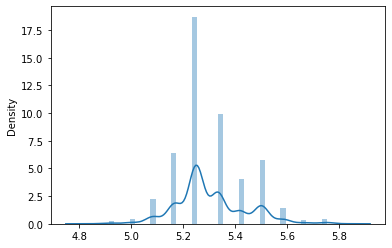

In [10]:
sns.distplot(np.array(list(IB_seq_presentation.values()))/len(MHC_list))

C:\Users\s2118339\anaconda3\envs\VC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

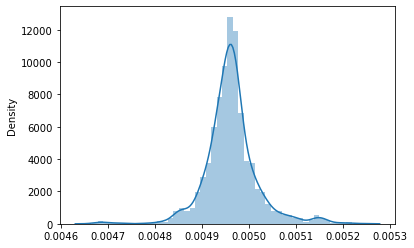

In [11]:
sns.distplot(np.array(list(IB_seq_scores.values()))/len(MHC_list))

## netMHCpan assessment

In [12]:
peptides_db = defaultdict(lambda: 0)
for key in IB_peptide_scores.keys():
    start = key.find("_") + 1
    peptides_db[key[start:start+9]] += 1
    
peptides_db = list(peptides_db.keys())

In [13]:
file = open(f"{NMP_FOLDER_1}{os.sep}peptides_db.pep", "w")
for peptide in peptides_db:
      file.writelines([peptide, "\n"])
    
file.close()

In [14]:
for mhc_name in MHC_list:
    # print(mhc_name)
    mhc_name_2 = mhc_name.replace(":", "").replace("HLA-", "")
    
    print(f"./netMHCpan -p {NMP_FOLDER_2}/peptides_db.pep -a {mhc_name} > {NMP_FOLDER_2}/peptides_db_{mhc_name_2}.pep.out")
    print("\n")

./netMHCpan -p ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/peptides_db.pep -a HLA-A01:01 > ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/peptides_db_A0101.pep.out


./netMHCpan -p ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/peptides_db.pep -a HLA-A02:01 > ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/peptides_db_A0201.pep.out


./netMHCpan -p ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/peptides_db.pep -a HLA-A03:01 > ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/peptides_db_A0301.pep.out


./netMHCpan -p ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/peptides_db.pep -a HLA-A24:02 > ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/peptides_db_A2402.pep.out


./netMHCpan -p ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/peptides_db.pep -a HLA-A26:01 > ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/peptides_db_A2601.pep.out


./netMHCpan -p ~/win/Docu

In [15]:
# run the above on Linux

In [16]:
nMp_peptide_scores = eval_peptides_nMp("peptides_db", MHC_list)

HLA-A01:01
peptide: MFVFLVLLP   rank_el: 68.333
peptide: FVFLVLLPL   rank_el: 43.909
peptide: VFLVLLPLV   rank_el: 46.25
peptide: FLVLLPLVS   rank_el: 43.364
peptide: LVLLPLVSS   rank_el: 55.8
peptide: VLLPLVSSQ   rank_el: 27.514
peptide: LLPLVSSQC   rank_el: 26.459
peptide: LPLVSSQCV   rank_el: 40.615
peptide: PLVSSQCVN   rank_el: 89.286
peptide: LVSSQCVNL   rank_el: 19.42
peptide: VSSQCVNLI   rank_el: 8.993
peptide: SSQCVNLIT   rank_el: 22.018
peptide: SQCVNLITR   rank_el: 15.027
peptide: QCVNLITRT   rank_el: 58.2
peptide: CVNLITRTQ   rank_el: 48.5
peptide: VNLITRTQS   rank_el: 76.818
peptide: NLITRTQSY   rank_el: 0.687
peptide: LITRTQSYT   rank_el: 38.714
peptide: ITRTQSYTN   rank_el: 32.591
peptide: TRTQSYTNS   rank_el: 81.25
peptide: RTQSYTNSF   rank_el: 1.175
peptide: TQSYTNSFT   rank_el: 31.792
peptide: QSYTNSFTR   rank_el: 5.841
peptide: SYTNSFTRG   rank_el: 73.077
peptide: YTNSFTRGV   rank_el: 3.524
peptide: TNSFTRGVY   rank_el: 1.9
peptide: NSFTRGVYY   rank_el: 0.218
peptide:

peptide: KTPPNKDFG   rank_el: 14.659
peptide: TPPNKDFGG   rank_el: 91.429
peptide: PPNKDFGGF   rank_el: 37.8
peptide: PNKDFGGFN   rank_el: 94.286
peptide: NKDFGGFNF   rank_el: 6.516
peptide: KHTPINLVH   rank_el: 11.982
peptide: HTPINLVHD   rank_el: 45.3
peptide: TPINLVHDL   rank_el: 24.174
peptide: PINLVHDLP   rank_el: 53.71
peptide: INLVHDLPQ   rank_el: 70.385
peptide: NLVHDLPQG   rank_el: 59.0
peptide: LVHDLPQGF   rank_el: 4.249
peptide: VHDLPQGFS   rank_el: 27.143
peptide: HDLPQGFSA   rank_el: 11.775
peptide: TSNFRVQPK   rank_el: 7.4
peptide: SNFRVQPKE   rank_el: 55.2
peptide: NFRVQPKES   rank_el: 78.182
peptide: FRVQPKESI   rank_el: 28.4
peptide: RVQPKESIV   rank_el: 13.193
peptide: VQPKESIVR   rank_el: 17.103
peptide: QPKESIVRF   rank_el: 4.593
peptide: PKESIVRFP   rank_el: 85.714
peptide: KESIVRFPN   rank_el: 87.857
peptide: NVFQTRAGG   rank_el: 64.762
peptide: VFQTRAGGL   rank_el: 39.769
peptide: FQTRAGGLI   rank_el: 26.568
peptide: QTRAGGLIG   rank_el: 39.692
peptide: TRAGGLIGA

peptide: PKIITTDNT   rank_el: 97.143
peptide: KIITTDNTF   rank_el: 9.175
peptide: ADYNYKLPA   rank_el: 28.2
peptide: DYNYKLPAD   rank_el: 97.143
peptide: YNYKLPADF   rank_el: 7.402
peptide: NYKLPADFT   rank_el: 48.75
peptide: YKLPADFTG   rank_el: 83.75
peptide: KLPADFTGC   rank_el: 41.583
peptide: LPADFTGCV   rank_el: 22.491
peptide: PADFTGCVI   rank_el: 6.907
peptide: ADFTGCVIA   rank_el: 41.0
peptide: DPFLDVYYY   rank_el: 2.759
peptide: PFLDVYYYK   rank_el: 40.0
peptide: FLDVYYYKN   rank_el: 7.941
peptide: LDVYYYKNN   rank_el: 95.0
peptide: DVYYYKNNK   rank_el: 26.324
peptide: VYYYKNNKS   rank_el: 73.462
peptide: YYYKNNKSW   rank_el: 10.598
peptide: YYKNNKSWM   rank_el: 22.754
peptide: YKNNKSWME   rank_el: 62.381
peptide: AVEQDKNTK   rank_el: 6.125
peptide: VEQDKNTKE   rank_el: 50.484
peptide: EQDKNTKEV   rank_el: 4.109
peptide: QDKNTKEVF   rank_el: 8.666
peptide: DKNTKEVFA   rank_el: 69.0
peptide: KNTKEVFAQ   rank_el: 54.677
peptide: NTKEVFAQV   rank_el: 5.916
peptide: TKEVFAQVK   r

peptide: ICASYKTQT   rank_el: 49.571
peptide: CASYKTQTN   rank_el: 46.375
peptide: ASYKTQTNS   rank_el: 20.0
peptide: SYKTQTNSR   rank_el: 29.414
peptide: YKTQTNSRR   rank_el: 45.2
peptide: KTQTNSRRR   rank_el: 10.251
peptide: GAGICASYR   rank_el: 45.2
peptide: AGICASYRT   rank_el: 72.692
peptide: GICASYRTQ   rank_el: 64.762
peptide: ICASYRTQT   rank_el: 44.8
peptide: CASYRTQTN   rank_el: 51.613
peptide: ASYRTQTNS   rank_el: 23.62
peptide: SYRTQTNSR   rank_el: 30.75
peptide: YRTQTNSRR   rank_el: 38.214
peptide: RTQTNSRRR   rank_el: 8.237
peptide: LPIGINITK   rank_el: 16.364
peptide: PIGINITKF   rank_el: 13.702
peptide: IGINITKFQ   rank_el: 59.2
peptide: GINITKFQT   rank_el: 47.889
peptide: INITKFQTL   rank_el: 14.897
peptide: NITKFQTLL   rank_el: 11.069
peptide: ITKFQTLLA   rank_el: 6.179
peptide: TKFQTLLAL   rank_el: 31.625
peptide: KFQTLLALH   rank_el: 17.682
peptide: ICASYQTQI   rank_el: 17.318
peptide: CASYQTQIN   rank_el: 53.871
peptide: ASYQTQINS   rank_el: 17.869
peptide: SYQTQI

peptide: SPAYTNSFT   rank_el: 40.077
peptide: DCTMYICGG   rank_el: 98.571
peptide: CTMYICGGS   rank_el: 75.455
peptide: TMYICGGST   rank_el: 63.571
peptide: MYICGGSTE   rank_el: 82.5
peptide: YICGGSTEC   rank_el: 37.8
peptide: ICGGSTECS   rank_el: 90.0
peptide: CGGSTECSN   rank_el: 97.143
peptide: GGSTECSNL   rank_el: 48.75
peptide: GSTECSNLL   rank_el: 10.382
peptide: SALEPLVDF   rank_el: 8.973
peptide: ALEPLVDFP   rank_el: 14.281
peptide: LEPLVDFPI   rank_el: 50.323
peptide: EPLVDFPIG   rank_el: 93.571
peptide: PLVDFPIGI   rank_el: 32.636
peptide: LVDFPIGIN   rank_el: 15.53
peptide: VDFPIGINI   rank_el: 11.452
peptide: DFPIGINIT   rank_el: 69.0
peptide: FPIGINITR   rank_el: 10.616
peptide: LHVTYVPAK   rank_el: 56.2
peptide: HVTYVPAKE   rank_el: 43.727
peptide: VTYVPAKEK   rank_el: 7.691
peptide: TYVPAKEKN   rank_el: 77.727
peptide: YVPAKEKNF   rank_el: 9.252
peptide: VPAKEKNFT   rank_el: 47.667
peptide: PAKEKNFTT   rank_el: 54.194
peptide: AKEKNFTTA   rank_el: 36.75
peptide: KEKNFTTA

peptide: CCKFDEDHS   rank_el: 91.429
peptide: CKFDEDHSE   rank_el: 84.375
peptide: KFDEDHSEP   rank_el: 14.53
peptide: FDEDHSEPV   rank_el: 7.621
peptide: DEDHSEPVL   rank_el: 8.215
peptide: EDHSEPVLK   rank_el: 7.377
peptide: DHSEPVLKG   rank_el: 45.2
peptide: HSEPVLKGV   rank_el: 3.878
peptide: LVSSQCVNR   rank_el: 23.22
peptide: VSSQCVNRT   rank_el: 22.649
peptide: SSQCVNRTT   rank_el: 31.458
peptide: SQCVNRTTR   rank_el: 21.097
peptide: QCVNRTTRT   rank_el: 56.4
peptide: CVNRTTRTQ   rank_el: 41.417
peptide: VNRTTRTQL   rank_el: 21.032
peptide: NRTTRTQLP   rank_el: 74.615
peptide: RTTRTQLPP   rank_el: 18.309
peptide: KSWMESEFS   rank_el: 22.193
peptide: SWMESEFSV   rank_el: 17.121
peptide: WMESEFSVY   rank_el: 0.206
peptide: MESEFSVYS   rank_el: 29.069
peptide: ESEFSVYSS   rank_el: 6.555
peptide: SEFSVYSSA   rank_el: 16.535
peptide: EFSVYSSAN   rank_el: 90.0
peptide: FSVYSSANN   rank_el: 43.455
peptide: SVYSSANNC   rank_el: 27.457
peptide: SHRRARSVV   rank_el: 31.208
peptide: HRRARS

peptide: NSPRRTRSV   rank_el: 15.06
peptide: SPRRTRSVA   rank_el: 25.488
peptide: PRRTRSVAS   rank_el: 97.857
peptide: NHPFLGVYY   rank_el: 3.005
peptide: HPFLGVYYH   rank_el: 10.653
peptide: TRFQTLLAF   rank_el: 9.404
peptide: RFQTLLAFH   rank_el: 19.481
peptide: FQTLLAFHR   rank_el: 24.261
peptide: QTLLAFHRS   rank_el: 18.457
peptide: TLLAFHRSY   rank_el: 1.939
peptide: LLAFHRSYL   rank_el: 10.09
peptide: LAFHRSYLT   rank_el: 21.048
peptide: AFHRSYLTP   rank_el: 57.8
peptide: FHRSYLTPG   rank_el: 77.727
peptide: CGSCCKFED   rank_el: 99.286
peptide: GSCCKFEDD   rank_el: 97.857
peptide: SCCKFEDDS   rank_el: 92.857
peptide: CCKFEDDSE   rank_el: 89.286
peptide: CKFEDDSEP   rank_el: 94.286
peptide: KFEDDSEPV   rank_el: 23.7
peptide: FEDDSEPVL   rank_el: 2.799
peptide: EIYQAGSTL   rank_el: 13.459
peptide: IYQAGSTLC   rank_el: 39.462
peptide: YQAGSTLCN   rank_el: 33.952
peptide: QAGSTLCNG   rank_el: 74.231
peptide: AGSTLCNGV   rank_el: 46.375
peptide: GSTLCNGVE   rank_el: 79.545
peptide: ST

peptide: FVSNGTDWF   rank_el: 14.798
peptide: VSNGTDWFV   rank_el: 4.507
peptide: SNGTDWFVT   rank_el: 75.0
peptide: NGTDWFVTQ   rank_el: 46.4
peptide: GTDWFVTQR   rank_el: 13.92
peptide: TDWFVTQRN   rank_el: 78.333
peptide: DWFVTQRNF   rank_el: 47.5
peptide: LNRALTGIS   rank_el: 90.0
peptide: NRALTGISV   rank_el: 28.63
peptide: RALTGISVE   rank_el: 40.75
peptide: ALTGISVEQ   rank_el: 7.687
peptide: LTGISVEQD   rank_el: 85.0
peptide: TGISVEQDK   rank_el: 57.727
peptide: GISVEQDKN   rank_el: 85.0
peptide: ISVEQDKNT   rank_el: 44.6
peptide: SVEQDKNTQ   rank_el: 49.75
peptide: RTQLPPAYA   rank_el: 5.298
peptide: TQLPPAYAN   rank_el: 32.389
peptide: QLPPAYANS   rank_el: 8.42
peptide: LPPAYANSF   rank_el: 35.462
peptide: PPAYANSFT   rank_el: 90.0
peptide: PAYANSFTR   rank_el: 33.375
peptide: AYANSFTRG   rank_el: 73.75
peptide: YANSFTRGV   rank_el: 2.453
peptide: ANSFTRGVY   rank_el: 63.125
peptide: NNKSWMESG   rank_el: 95.0
peptide: NKSWMESGV   rank_el: 63.75
peptide: KSWMESGVY   rank_el: 3

peptide: TPNLVRDLP   rank_el: 66.667
peptide: PNLVRDLPQ   rank_el: 100.0
peptide: VNCTEVPVV   rank_el: 16.93
peptide: NCTEVPVVI   rank_el: 10.606
peptide: CTEVPVVIH   rank_el: 52.333
peptide: TEVPVVIHA   rank_el: 8.751
peptide: EVPVVIHAD   rank_el: 58.182
peptide: VPVVIHADQ   rank_el: 95.0
peptide: PVVIHADQL   rank_el: 27.903
peptide: VVIHADQLT   rank_el: 19.777
peptide: VIHADQLTP   rank_el: 16.56
peptide: HWFVTQRNL   rank_el: 16.935
peptide: WFVTQRNLY   rank_el: 48.0
peptide: FVTQRNLYE   rank_el: 27.355
peptide: VTQRNLYEP   rank_el: 26.842
peptide: TQRNLYEPQ   rank_el: 58.636
peptide: QRNLYEPQI   rank_el: 21.118
peptide: RNLYEPQII   rank_el: 31.8
peptide: NLYEPQIIT   rank_el: 1.038
peptide: LYEPQIITT   rank_el: 21.645
peptide: RRRARSVAI   rank_el: 28.259
peptide: RRARSVAIQ   rank_el: 78.333
peptide: RARSVAIQS   rank_el: 32.667
peptide: ARSVAIQSI   rank_el: 19.01
peptide: RSVAIQSII   rank_el: 16.445
peptide: SVAIQSIIA   rank_el: 9.866
peptide: VAIQSIIAY   rank_el: 14.904
peptide: AIQSI

peptide: PFFSNVTLF   rank_el: 26.526
peptide: FFSNVTLFH   rank_el: 18.169
peptide: FSNVTLFHA   rank_el: 6.049
peptide: SNVTLFHAI   rank_el: 13.866
peptide: NVTLFHAIH   rank_el: 46.8
peptide: VTLFHAIHV   rank_el: 1.842
peptide: TLFHAIHVS   rank_el: 2.475
peptide: LFHAIHVSG   rank_el: 63.75
peptide: TQTNSRRRV   rank_el: 18.347
peptide: QTNSRRRVR   rank_el: 55.0
peptide: TNSRRRVRS   rank_el: 87.5
peptide: NSRRRVRSV   rank_el: 30.864
peptide: SRRRVRSVA   rank_el: 72.5
peptide: RRRVRSVAS   rank_el: 72.5
peptide: LIGAEHVNY   rank_el: 25.171
peptide: IGAEHVNYS   rank_el: 24.771
peptide: GAEHVNYSY   rank_el: 23.473
peptide: AEHVNYSYE   rank_el: 78.333
peptide: EHVNYSYEC   rank_el: 47.25
peptide: HVNYSYECD   rank_el: 78.333
peptide: VNYSYECDI   rank_el: 41.143
peptide: NYSYECDIP   rank_el: 95.0
peptide: YSYECDIPI   rank_el: 3.407
peptide: QPYRVVVLY   rank_el: 30.727
peptide: PYRVVVLYF   rank_el: 68.333
peptide: YRVVVLYFE   rank_el: 59.091
peptide: RVVVLYFEL   rank_el: 4.529
peptide: VVVLYFELL  

peptide: GWVFGTTLD   rank_el: 95.0
peptide: WVFGTTLDS   rank_el: 26.947
peptide: VFGTTLDSK   rank_el: 45.833
peptide: EPLVDLPIC   rank_el: 55.0
peptide: PLVDLPICI   rank_el: 2.728
peptide: LVDLPICIN   rank_el: 54.667
peptide: VDLPICINI   rank_el: 18.185
peptide: DLPICINIT   rank_el: 34.286
peptide: LPICINITR   rank_el: 61.25
peptide: PICINITRF   rank_el: 40.875
peptide: ICINITRFQ   rank_el: 47.25
peptide: CINITRFQT   rank_el: 37.2
peptide: HRSYLTPGA   rank_el: 49.5
peptide: RSYLTPGAS   rank_el: 35.077
peptide: SYLTPGASS   rank_el: 38.4
peptide: YLTPGASSS   rank_el: 4.674
peptide: LTPGASSSG   rank_el: 60.0
peptide: TPGASSSGW   rank_el: 65.0
peptide: PGASSSGWT   rank_el: 95.0
peptide: GASSSGWTA   rank_el: 10.661
peptide: ASSSGWTAG   rank_el: 65.0
peptide: GAISSVLNE   rank_el: 32.278
peptide: AISSVLNEI   rank_el: 0.524
peptide: ISSVLNEIL   rank_el: 12.161
peptide: SSVLNEILS   rank_el: 43.571
peptide: SVLNEILSR   rank_el: 8.378
peptide: VLNEILSRL   rank_el: 0.028
peptide: LNEILSRLD   rank_

peptide: RTTRTQLPP   rank_el: 36.167
peptide: KSWMESEFS   rank_el: 33.0
peptide: SWMESEFSV   rank_el: 2.434
peptide: WMESEFSVY   rank_el: 18.089
peptide: MESEFSVYS   rank_el: 32.389
peptide: ESEFSVYSS   rank_el: 57.727
peptide: SEFSVYSSA   rank_el: 14.116
peptide: EFSVYSSAN   rank_el: 90.0
peptide: FSVYSSANN   rank_el: 78.333
peptide: SVYSSANNC   rank_el: 6.262
peptide: SHRRARSVV   rank_el: 58.636
peptide: HRRARSVVS   rank_el: 80.0
peptide: LPVSMTKTA   rank_el: 39.778
peptide: PVSMTKTAV   rank_el: 23.109
peptide: VSMTKTAVD   rank_el: 73.75
peptide: SMTKTAVDC   rank_el: 11.139
peptide: MTKTAVDCT   rank_el: 45.5
peptide: TKTAVDCTM   rank_el: 58.636
peptide: KTAVDCTMY   rank_el: 29.68
peptide: TAVDCTMYI   rank_el: 4.976
peptide: AVDCTMYIC   rank_el: 18.371
peptide: GKLQDVVNK   rank_el: 36.25
peptide: KLQDVVNKN   rank_el: 12.082
peptide: LQDVVNKNA   rank_el: 10.551
peptide: QDVVNKNAQ   rank_el: 95.0
peptide: DVVNKNAQA   rank_el: 19.117
peptide: VVNKNAQAL   rank_el: 4.469
peptide: VNKNAQALN

peptide: ADAGFIRQY   rank_el: 22.646
peptide: DAGFIRQYG   rank_el: 90.0
peptide: AGFIRQYGD   rank_el: 85.0
peptide: GFIRQYGDC   rank_el: 82.5
peptide: FIRQYGDCL   rank_el: 8.552
peptide: IRQYGDCLG   rank_el: 95.0
peptide: RQYGDCLGD   rank_el: 37.9
peptide: SNVTWFHAN   rank_el: 78.333
peptide: NVTWFHANV   rank_el: 5.056
peptide: VTWFHANVS   rank_el: 31.15
peptide: TWFHANVSG   rank_el: 47.5
peptide: WFHANVSGT   rank_el: 58.636
peptide: FHANVSGTN   rank_el: 90.0
peptide: HANVSGTNG   rank_el: 80.0
peptide: ANVSGTNGT   rank_el: 52.0
peptide: NVSGTNGTK   rank_el: 33.312
peptide: TRTQLPPAD   rank_el: 90.0
peptide: RTQLPPADT   rank_el: 25.927
peptide: TQLPPADTN   rank_el: 44.8
peptide: QLPPADTNS   rank_el: 16.045
peptide: LPPADTNSF   rank_el: 30.955
peptide: PPADTNSFT   rank_el: 80.0
peptide: PADTNSFTR   rank_el: 43.286
peptide: ADTNSFTRG   rank_el: 87.5
peptide: DTNSFTRGV   rank_el: 11.889
peptide: SKTQSLLIF   rank_el: 46.0
peptide: KTQSLLIFN   rank_el: 47.0
peptide: TQSLLIFNN   rank_el: 53.6

peptide: CNGVEGLNC   rank_el: 82.5
peptide: NGVEGLNCY   rank_el: 47.75
peptide: GVEGLNCYF   rank_el: 17.91
peptide: VEGLNCYFP   rank_el: 78.333
peptide: EGLNCYFPL   rank_el: 38.9
peptide: GLNCYFPLQ   rank_el: 23.618
peptide: LNCYFPLQS   rank_el: 68.333
peptide: PRRARSVAI   rank_el: 72.5


HLA-A03:01
peptide: MFVFLVLLP   rank_el: 48.5
peptide: FVFLVLLPL   rank_el: 18.071
peptide: VFLVLLPLV   rank_el: 28.6
peptide: FLVLLPLVS   rank_el: 32.778
peptide: LVLLPLVSS   rank_el: 14.101
peptide: VLLPLVSSQ   rank_el: 4.519
peptide: LLPLVSSQC   rank_el: 32.667
peptide: LPLVSSQCV   rank_el: 52.5
peptide: PLVSSQCVN   rank_el: 90.0
peptide: LVSSQCVNL   rank_el: 18.186
peptide: VSSQCVNLI   rank_el: 29.385
peptide: SSQCVNLIT   rank_el: 61.25
peptide: SQCVNLITR   rank_el: 3.458
peptide: QCVNLITRT   rank_el: 52.5
peptide: CVNLITRTQ   rank_el: 11.355
peptide: VNLITRTQS   rank_el: 49.667
peptide: NLITRTQSY   rank_el: 2.507
peptide: LITRTQSYT   rank_el: 43.667
peptide: ITRTQSYTN   rank_el: 23.0
peptide: TRT

peptide: AVDCALDPL   rank_el: 45.667
peptide: VDCALDPLS   rank_el: 82.5
peptide: DCALDPLSE   rank_el: 77.5
peptide: CALDPLSET   rank_el: 36.667
peptide: ALDPLSETK   rank_el: 0.413
peptide: LDPLSETKC   rank_el: 82.5
peptide: DPLSETKCT   rank_el: 75.0
peptide: PLSETKCTL   rank_el: 40.0
peptide: LSETKCTLK   rank_el: 3.405
peptide: SETKCTLKS   rank_el: 48.5
peptide: ETKCTLKSF   rank_el: 28.067
peptide: TKCTLKSFT   rank_el: 80.0
peptide: KCTLKSFTV   rank_el: 33.5
peptide: CTLKSFTVE   rank_el: 20.304
peptide: TLKSFTVEK   rank_el: 0.03
peptide: LKSFTVEKG   rank_el: 90.0
peptide: KSFTVEKGI   rank_el: 13.956
peptide: SFTVEKGIY   rank_el: 15.808
peptide: FTVEKGIYQ   rank_el: 10.567
peptide: TVEKGIYQT   rank_el: 24.96
peptide: VEKGIYQTS   rank_el: 45.333
peptide: EKGIYQTSN   rank_el: 90.0
peptide: KGIYQTSNF   rank_el: 12.257
peptide: GIYQTSNFR   rank_el: 0.386
peptide: IYQTSNFRV   rank_el: 26.842
peptide: YQTSNFRVQ   rank_el: 21.513
peptide: QTSNFRVQP   rank_el: 16.66
peptide: TSNFRVQPT   rank_el

peptide: DKNTEEVFA   rank_el: 70.0
peptide: KNTEEVFAQ   rank_el: 28.267
peptide: NTEEVFAQV   rank_el: 20.739
peptide: TEEVFAQVK   rank_el: 14.684
peptide: EEVFAQVKQ   rank_el: 48.5
peptide: EYVSQPFLI   rank_el: 26.842
peptide: YVSQPFLID   rank_el: 51.25
peptide: VSQPFLIDL   rank_el: 16.73
peptide: SQPFLIDLE   rank_el: 35.0
peptide: QPFLIDLEG   rank_el: 59.286
peptide: PFLIDLEGK   rank_el: 19.807
peptide: FLIDLEGKQ   rank_el: 22.4
peptide: LIDLEGKQG   rank_el: 71.667
peptide: IDLEGKQGN   rank_el: 90.0
peptide: QGVNCTEVS   rank_el: 87.5
peptide: GVNCTEVSV   rank_el: 28.267
peptide: VNCTEVSVA   rank_el: 65.0
peptide: NCTEVSVAI   rank_el: 53.75
peptide: CTEVSVAIH   rank_el: 12.928
peptide: TEVSVAIHA   rank_el: 28.8
peptide: EVSVAIHAD   rank_el: 77.5
peptide: VSVAIHADQ   rank_el: 29.077
peptide: SVAIHADQL   rank_el: 16.74
peptide: QQLIRAAEV   rank_el: 33.5
peptide: QLIRAAEVR   rank_el: 5.789
peptide: LIRAAEVRA   rank_el: 22.257
peptide: IRAAEVRAS   rank_el: 55.0
peptide: RAAEVRASA   rank_el

peptide: QSNKKFLPF   rank_el: 7.491
peptide: LQSLQTYVI   rank_el: 36.167
peptide: QSLQTYVIQ   rank_el: 19.088
peptide: SLQTYVIQQ   rank_el: 4.608
peptide: LQTYVIQQL   rank_el: 20.87
peptide: QTYVIQQLI   rank_el: 9.797
peptide: TYVIQQLIR   rank_el: 10.124
peptide: YVIQQLIRA   rank_el: 12.075
peptide: VIQQLIRAA   rank_el: 14.411
peptide: IQQLIRAAE   rank_el: 22.314
peptide: VLLPLVSSN   rank_el: 18.214
peptide: LLPLVSSNL   rank_el: 20.739
peptide: LPLVSSNLR   rank_el: 14.165
peptide: PLVSSNLRT   rank_el: 59.286
peptide: LVSSNLRTR   rank_el: 1.928
peptide: VSSNLRTRT   rank_el: 33.75
peptide: SSNLRTRTQ   rank_el: 9.639
peptide: SNLRTRTQL   rank_el: 23.034
peptide: RLFRKSNLE   rank_el: 3.356
peptide: LFRKSNLEP   rank_el: 30.0
peptide: FRKSNLEPF   rank_el: 28.067
peptide: RKSNLEPFE   rank_el: 50.0
peptide: KSNLEPFER   rank_el: 1.978
peptide: SNLEPFERD   rank_el: 77.5
peptide: NLEPFERDI   rank_el: 40.4
peptide: LEPFERDIS   rank_el: 95.0
peptide: EPFERDIST   rank_el: 39.25
peptide: VKQIYKTPS   

peptide: TTSPAICHD   rank_el: 56.429
peptide: TSPAICHDG   rank_el: 90.0
peptide: SPAICHDGK   rank_el: 11.645
peptide: QLNRALTGV   rank_el: 11.603
peptide: LNRALTGVA   rank_el: 45.667
peptide: NRALTGVAI   rank_el: 42.5
peptide: RALTGVAIE   rank_el: 21.564
peptide: ALTGVAIEQ   rank_el: 6.866
peptide: LTGVAIEQD   rank_el: 90.0
peptide: TGVAIEQDK   rank_el: 14.367
peptide: GVAIEQDKN   rank_el: 82.5
peptide: VAIEQDKNT   rank_el: 77.5
peptide: AIEQDKNTQ   rank_el: 26.632
peptide: IEQDKNTQE   rank_el: 50.625
peptide: QMAYRFNGV   rank_el: 21.077
peptide: MAYRFNGVG   rank_el: 75.0
peptide: AYRFNGVGV   rank_el: 27.625
peptide: YRFNGVGVT   rank_el: 54.375
peptide: RFNGVGVTQ   rank_el: 5.452
peptide: FNGVGVTQN   rank_el: 87.5
peptide: NGVGVTQNV   rank_el: 46.333
peptide: GVGVTQNVL   rank_el: 25.667
peptide: VGVTQNVLY   rank_el: 9.79
peptide: LREFVFKNV   rank_el: 66.25
peptide: REFVFKNVD   rank_el: 82.5
peptide: ESLIDLQEF   rank_el: 33.75
peptide: SLIDLQEFG   rank_el: 37.333
peptide: LIDLQEFGK   ra

peptide: IAGLMAIVM   rank_el: 55.0
peptide: AGLMAIVMV   rank_el: 40.8
peptide: GLMAIVMVT   rank_el: 15.875
peptide: LMAIVMVTI   rank_el: 27.0
peptide: MAIVMVTIM   rank_el: 44.333
peptide: DISTEIYQV   rank_el: 28.133
peptide: ISTEIYQVG   rank_el: 70.0
peptide: STEIYQVGS   rank_el: 40.4
peptide: TEIYQVGSK   rank_el: 9.237
peptide: EIYQVGSKP   rank_el: 17.37
peptide: IYQVGSKPC   rank_el: 58.571
peptide: YQVGSKPCN   rank_el: 73.333
peptide: QVGSKPCNG   rank_el: 52.5
peptide: VGSKPCNGV   rank_el: 42.25
peptide: HTPINLVRE   rank_el: 26.737
peptide: TPINLVREL   rank_el: 21.641
peptide: PINLVRELP   rank_el: 71.667
peptide: INLVRELPQ   rank_el: 44.0
peptide: NLVRELPQG   rank_el: 61.25
peptide: LVRELPQGF   rank_el: 8.956
peptide: VRELPQGFS   rank_el: 71.667
peptide: RELPQGFSA   rank_el: 15.417
peptide: ELPQGFSAL   rank_el: 16.91
peptide: HTPINLVRH   rank_el: 5.951
peptide: TPINLVRHL   rank_el: 22.286
peptide: PINLVRHLP   rank_el: 53.75
peptide: INLVRHLPQ   rank_el: 36.667
peptide: NLVRHLPQG   ra

peptide: LASTKMSEC   rank_el: 39.0
peptide: ASTKMSECV   rank_el: 54.375
peptide: STKMSECVL   rank_el: 20.957
peptide: TFKCYGVSS   rank_el: 43.0
peptide: FKCYGVSST   rank_el: 77.5
peptide: KCYGVSSTK   rank_el: 0.262
peptide: CYGVSSTKL   rank_el: 44.333
peptide: YGVSSTKLN   rank_el: 82.5
peptide: GVSSTKLND   rank_el: 57.857
peptide: VSSTKLNDL   rank_el: 36.5
peptide: SSTKLNDLC   rank_el: 59.286
peptide: STKLNDLCF   rank_el: 19.386
peptide: FTVEKGIYK   rank_el: 0.405
peptide: TVEKGIYKT   rank_el: 27.938
peptide: VEKGIYKTS   rank_el: 53.125
peptide: EKGIYKTSN   rank_el: 95.0
peptide: KGIYKTSNF   rank_el: 11.133
peptide: GIYKTSNFR   rank_el: 0.292
peptide: IYKTSNFRV   rank_el: 29.538
peptide: YKTSNFRVQ   rank_el: 50.0
peptide: KTSNFRVQP   rank_el: 8.169
peptide: EDDSEPVLN   rank_el: 80.0
peptide: DDSEPVLNG   rank_el: 67.5
peptide: DSEPVLNGV   rank_el: 39.5
peptide: SEPVLNGVK   rank_el: 16.29
peptide: EPVLNGVKL   rank_el: 42.25
peptide: PVLNGVKLH   rank_el: 10.465
peptide: VLNGVKLHY   rank_e

peptide: YFPLHSYGF   rank_el: 23.897
peptide: FPLHSYGFQ   rank_el: 49.0
peptide: PLHSYGFQP   rank_el: 53.125
peptide: LHSYGFQPT   rank_el: 71.667
peptide: HSYGFQPTY   rank_el: 0.575
peptide: CMTSCCSCF   rank_el: 53.125
peptide: MTSCCSCFK   rank_el: 3.993
peptide: TSCCSCFKG   rank_el: 90.0
peptide: SCCSCFKGC   rank_el: 77.5
peptide: CCSCFKGCC   rank_el: 100.0
peptide: CSCFKGCCS   rank_el: 77.5
peptide: SCFKGCCSC   rank_el: 55.0
peptide: CFKGCCSCG   rank_el: 95.0
peptide: FKGCCSCGS   rank_el: 100.0
peptide: ITGRLQSLH   rank_el: 3.951
peptide: TGRLQSLHT   rank_el: 43.0
peptide: GRLQSLHTY   rank_el: 5.349
peptide: RLQSLHTYV   rank_el: 4.719
peptide: LQSLHTYVT   rank_el: 43.333
peptide: QSLHTYVTQ   rank_el: 13.611
peptide: SLHTYVTQQ   rank_el: 4.28
peptide: LHTYVTQQL   rank_el: 30.545
peptide: HTYVTQQLI   rank_el: 7.463
peptide: EDLLFNKVI   rank_el: 58.571
peptide: DLLFNKVIL   rank_el: 36.0
peptide: LLFNKVILA   rank_el: 3.396
peptide: LFNKVILAD   rank_el: 55.0
peptide: FNKVILADA   rank_el: 

peptide: AHFPREGVF   rank_el: 1.971
peptide: HFPREGVFV   rank_el: 1.652
peptide: FPREGVFVS   rank_el: 50.0
peptide: PREGVFVSN   rank_el: 70.0
peptide: REGVFVSNG   rank_el: 67.5
peptide: EGVFVSNGT   rank_el: 58.333
peptide: GVFVSNGTH   rank_el: 67.5
peptide: VFVSNGTHW   rank_el: 0.132
peptide: FVSNGTHWF   rank_el: 1.436
peptide: VSNGTHWFV   rank_el: 5.761
peptide: SNGTHWFVT   rank_el: 42.0
peptide: NGTHWFVTQ   rank_el: 49.0
peptide: GTHWFVTQR   rank_el: 21.091
peptide: THWFVTQRN   rank_el: 36.333
peptide: HWFVTQRNF   rank_el: 0.188
peptide: WFVTQRNFY   rank_el: 6.302
peptide: FVTQRNFYE   rank_el: 51.25
peptide: VTQRNFYEP   rank_el: 21.5
peptide: TQRNFYEPQ   rank_el: 56.667
peptide: QRNFYEPQI   rank_el: 9.591
peptide: RNFYEPQII   rank_el: 6.537
peptide: NFYEPQIIT   rank_el: 10.252
peptide: FYEPQIITT   rank_el: 2.714
peptide: YEPQIITTD   rank_el: 31.5
peptide: EPQIITTDN   rank_el: 100.0
peptide: PQIITTDNT   rank_el: 67.5
peptide: QIITTDNTF   rank_el: 2.087
peptide: IITTDNTFV   rank_el: 33

peptide: VSSQCVNFT   rank_el: 50.0
peptide: SSQCVNFTN   rank_el: 65.0
peptide: SQCVNFTNR   rank_el: 20.889
peptide: QCVNFTNRT   rank_el: 80.0
peptide: CVNFTNRTQ   rank_el: 80.0
peptide: VNFTNRTQL   rank_el: 7.457
peptide: NFTNRTQLP   rank_el: 15.667
peptide: FTNRTQLPS   rank_el: 67.5
peptide: TNRTQLPSA   rank_el: 50.0
peptide: NRTQLPSAY   rank_el: 9.832
peptide: RTQLPSAYT   rank_el: 33.75
peptide: TQLPSAYTN   rank_el: 18.605
peptide: QLPSAYTNS   rank_el: 22.895
peptide: LPSAYTNSF   rank_el: 4.205
peptide: PSAYTNSFT   rank_el: 80.0
peptide: SAYTNSFTR   rank_el: 10.313
peptide: VCEFQFCNY   rank_el: 39.5
peptide: CEFQFCNYP   rank_el: 65.0
peptide: EFQFCNYPF   rank_el: 1.406
peptide: FQFCNYPFL   rank_el: 4.242
peptide: QFCNYPFLG   rank_el: 15.725
peptide: FCNYPFLGV   rank_el: 29.0
peptide: CNYPFLGVY   rank_el: 22.105
peptide: NYPFLGVYH   rank_el: 4.292
peptide: YPFLGVYHK   rank_el: 16.782
peptide: PFLGVYHKN   rank_el: 13.658
peptide: FLGVYHKNN   rank_el: 90.0
peptide: LGVYHKNNK   rank_el: 

peptide: KMQDSLSST   rank_el: 34.5
peptide: MQDSLSSTA   rank_el: 18.974
peptide: PELDSFKED   rank_el: 90.0
peptide: ELDSFKEDL   rank_el: 14.711
peptide: LDSFKEDLD   rank_el: 90.0
peptide: DSFKEDLDK   rank_el: 67.5
peptide: SFKEDLDKY   rank_el: 2.532
peptide: FKEDLDKYF   rank_el: 8.794
peptide: KEDLDKYFK   rank_el: 27.8
peptide: EDLDKYFKN   rank_el: 56.667
peptide: DLDKYFKNH   rank_el: 28.5
peptide: QDLFLPFFA   rank_el: 36.667
peptide: DLFLPFFAN   rank_el: 65.0
peptide: LFLPFFANV   rank_el: 1.897
peptide: FLPFFANVT   rank_el: 28.25
peptide: LPFFANVTW   rank_el: 3.971
peptide: PFFANVTWF   rank_el: 0.463
peptide: FFANVTWFH   rank_el: 5.852
peptide: FANVTWFHA   rank_el: 39.0
peptide: ANVTWFHAI   rank_el: 6.135
peptide: TKTSVDCTI   rank_el: 30.667
peptide: KTSVDCTIY   rank_el: 26.3
peptide: TSVDCTIYI   rank_el: 12.292
peptide: SVDCTIYIC   rank_el: 44.0
peptide: VDCTIYICG   rank_el: 90.0
peptide: DCTIYICGD   rank_el: 100.0
peptide: CTIYICGDS   rank_el: 100.0
peptide: TIYICGDST   rank_el: 80.

peptide: VFGTNGTKR   rank_el: 13.261
peptide: FGTNGTKRF   rank_el: 5.687
peptide: ASALGKLQH   rank_el: 46.0
peptide: SALGKLQHV   rank_el: 8.922
peptide: ALGKLQHVV   rank_el: 12.861
peptide: LGKLQHVVN   rank_el: 90.0
peptide: GKLQHVVNQ   rank_el: 60.0
peptide: KLQHVVNQN   rank_el: 48.0
peptide: LQHVVNQNA   rank_el: 34.75
peptide: QHVVNQNAQ   rank_el: 43.5
peptide: HVVNQNAQA   rank_el: 58.333
peptide: QPELDSFKK   rank_el: 47.0
peptide: PELDSFKKE   rank_el: 70.0
peptide: ELDSFKKEL   rank_el: 9.9
peptide: LDSFKKELD   rank_el: 90.0
peptide: DSFKKELDK   rank_el: 47.0
peptide: SFKKELDKY   rank_el: 2.378
peptide: FKKELDKYF   rank_el: 8.834
peptide: KKELDKYFK   rank_el: 45.5
peptide: KELDKYFKN   rank_el: 43.0
peptide: SNNSIAIPI   rank_el: 15.971
peptide: NNSIAIPIN   rank_el: 90.0
peptide: NSIAIPINF   rank_el: 1.21
peptide: SIAIPINFT   rank_el: 42.5
peptide: IAIPINFTI   rank_el: 1.324
peptide: AIPINFTIS   rank_el: 35.75
peptide: IPINFTISV   rank_el: 11.087
peptide: PINFTISVT   rank_el: 90.0
pept

peptide: LAGTVTSGW   rank_el: 8.855
peptide: AGTVTSGWT   rank_el: 90.0
peptide: GTVTSGWTF   rank_el: 1.419
peptide: TVTSGWTFG   rank_el: 65.0
peptide: VTSGWTFGA   rank_el: 32.8
peptide: PIKDFGGFD   rank_el: 100.0
peptide: IKDFGGFDF   rank_el: 6.641
peptide: KDFGGFDFS   rank_el: 46.0
peptide: DFGGFDFSQ   rank_el: 31.5
peptide: FGGFDFSQI   rank_el: 14.533
peptide: GGFDFSQIL   rank_el: 11.663
peptide: GFDFSQILP   rank_el: 13.964
peptide: FDFSQILPD   rank_el: 70.0
peptide: DFSQILPDP   rank_el: 19.935
peptide: HKNNKSWMQ   rank_el: 55.0
peptide: KNNKSWMQS   rank_el: 58.333
peptide: NNKSWMQSG   rank_el: 67.5
peptide: NKSWMQSGV   rank_el: 45.0
peptide: KSWMQSGVY   rank_el: 24.643
peptide: SWMQSGVYS   rank_el: 8.641
peptide: WMQSGVYSS   rank_el: 33.0
peptide: MQSGVYSSA   rank_el: 18.105
peptide: QSGVYSSAN   rank_el: 100.0
peptide: FELLHAPAA   rank_el: 30.333
peptide: ELLHAPAAV   rank_el: 26.7
peptide: LLHAPAAVC   rank_el: 46.0
peptide: LHAPAAVCG   rank_el: 40.5
peptide: HAPAAVCGP   rank_el: 55.

peptide: CHLMSFPQS   rank_el: 41.0
peptide: NDLCFTNVH   rank_el: 80.0
peptide: DLCFTNVHA   rank_el: 49.0
peptide: LCFTNVHAD   rank_el: 90.0
peptide: CFTNVHADS   rank_el: 35.25
peptide: FTNVHADSF   rank_el: 2.595
peptide: TNVHADSFV   rank_el: 37.0
peptide: NVHADSFVI   rank_el: 15.942
peptide: VHADSFVIR   rank_el: 8.784
peptide: HADSFVIRG   rank_el: 39.0
peptide: MTSCCSCLN   rank_el: 100.0
peptide: TSCCSCLNG   rank_el: 100.0
peptide: SCCSCLNGC   rank_el: 80.0
peptide: CCSCLNGCC   rank_el: 100.0
peptide: CSCLNGCCS   rank_el: 100.0
peptide: SCLNGCCSC   rank_el: 70.0
peptide: CLNGCCSCG   rank_el: 100.0
peptide: LNGCCSCGS   rank_el: 100.0
peptide: NGCCSCGSC   rank_el: 90.0
peptide: VLYQGVNCI   rank_el: 5.651
peptide: LYQGVNCIE   rank_el: 14.144
peptide: YQGVNCIEV   rank_el: 13.577
peptide: QGVNCIEVP   rank_el: 67.5
peptide: GVNCIEVPV   rank_el: 67.5
peptide: VNCIEVPVA   rank_el: 47.0
peptide: NCIEVPVAI   rank_el: 13.252
peptide: CIEVPVAIH   rank_el: 80.0
peptide: IEVPVAIHA   rank_el: 28.125


peptide: PVLKGIKLH   rank_el: 41.0
peptide: VLKGIKLHY   rank_el: 3.598
peptide: STEIYQAGG   rank_el: 90.0
peptide: TEIYQAGGT   rank_el: 70.0
peptide: EIYQAGGTP   rank_el: 60.0
peptide: IYQAGGTPC   rank_el: 5.44
peptide: YQAGGTPCN   rank_el: 43.5
peptide: QAGGTPCNG   rank_el: 90.0
peptide: AGGTPCNGV   rank_el: 39.5
peptide: GGTPCNGVE   rank_el: 100.0
peptide: GTPCNGVEG   rank_el: 60.0
peptide: TEIYQAGIT   rank_el: 70.0
peptide: EIYQAGITP   rank_el: 45.0
peptide: IYQAGITPC   rank_el: 3.72
peptide: YQAGITPCN   rank_el: 43.0
peptide: QAGITPCNG   rank_el: 90.0
peptide: AGITPCNGV   rank_el: 30.833
peptide: GITPCNGVE   rank_el: 90.0
peptide: ITPCNGVEG   rank_el: 50.0
peptide: TVYDPLQPQ   rank_el: 40.5
peptide: VYDPLQPQL   rank_el: 0.048
peptide: YDPLQPQLD   rank_el: 51.25
peptide: DPLQPQLDS   rank_el: 53.75
peptide: PLQPQLDSF   rank_el: 1.368
peptide: LQPQLDSFK   rank_el: 19.258
peptide: QPQLDSFKE   rank_el: 55.0
peptide: PQLDSFKEE   rank_el: 51.25
peptide: QLDSFKEEL   rank_el: 5.971
peptide:

peptide: PCNGVEGLN   rank_el: 100.0
peptide: CNGVEGLNC   rank_el: 80.0
peptide: NGVEGLNCY   rank_el: 30.167
peptide: GVEGLNCYF   rank_el: 8.861
peptide: VEGLNCYFP   rank_el: 58.333
peptide: EGLNCYFPL   rank_el: 19.548
peptide: GLNCYFPLQ   rank_el: 65.0
peptide: LNCYFPLQS   rank_el: 67.5
peptide: PRRARSVAI   rank_el: 29.571


HLA-A26:01
peptide: MFVFLVLLP   rank_el: 55.714
peptide: FVFLVLLPL   rank_el: 5.236
peptide: VFLVLLPLV   rank_el: 39.833
peptide: FLVLLPLVS   rank_el: 53.636
peptide: LVLLPLVSS   rank_el: 32.818
peptide: VLLPLVSSQ   rank_el: 20.604
peptide: LLPLVSSQC   rank_el: 28.235
peptide: LPLVSSQCV   rank_el: 29.438
peptide: PLVSSQCVN   rank_el: 75.0
peptide: LVSSQCVNL   rank_el: 8.689
peptide: VSSQCVNLI   rank_el: 23.235
peptide: SSQCVNLIT   rank_el: 67.5
peptide: SQCVNLITR   rank_el: 12.528
peptide: QCVNLITRT   rank_el: 50.909
peptide: CVNLITRTQ   rank_el: 17.944
peptide: VNLITRTQS   rank_el: 80.0
peptide: NLITRTQSY   rank_el: 0.085
peptide: LITRTQSYT   rank_el: 54.091
pepti

peptide: SNEIYQAGS   rank_el: 85.0
peptide: NEIYQAGST   rank_el: 45.0
peptide: KWPWYIWLC   rank_el: 43.0
peptide: WPWYIWLCF   rank_el: 10.88
peptide: PWYIWLCFI   rank_el: 61.0
peptide: WYIWLCFIA   rank_el: 80.0
peptide: YIWLCFIAG   rank_el: 90.0
peptide: IWLCFIAGL   rank_el: 44.25
peptide: WLCFIAGLI   rank_el: 57.143
peptide: LCFIAGLIA   rank_el: 80.0
peptide: CFIAGLIAI   rank_el: 22.053
peptide: LDSFKEELY   rank_el: 6.216
peptide: DSFKEELYK   rank_el: 5.546
peptide: SFKEELYKY   rank_el: 0.617
peptide: FKEELYKYF   rank_el: 7.766
peptide: KEELYKYFK   rank_el: 42.2
peptide: EELYKYFKN   rank_el: 64.0
peptide: ELYKYFKNH   rank_el: 1.721
peptide: LYKYFKNHT   rank_el: 62.0
peptide: YKYFKNHTS   rank_el: 41.8
peptide: SCLKGCCSF   rank_el: 18.278
peptide: CLKGCCSFG   rank_el: 90.0
peptide: LKGCCSFGS   rank_el: 100.0
peptide: KGCCSFGSC   rank_el: 95.0
peptide: GCCSFGSCC   rank_el: 95.0
peptide: CCSFGSCCK   rank_el: 80.0
peptide: CSFGSCCKF   rank_el: 4.113
peptide: SFGSCCKFD   rank_el: 100.0
pept

peptide: TYAVRDPQT   rank_el: 58.571
peptide: YAVRDPQTL   rank_el: 3.603
peptide: GTKRFDNPF   rank_el: 3.824
peptide: TKRFDNPFL   rank_el: 30.333
peptide: KRFDNPFLP   rank_el: 31.357
peptide: RFDNPFLPF   rank_el: 3.762
peptide: FDNPFLPFN   rank_el: 55.714
peptide: DNPFLPFND   rank_el: 95.0
peptide: NPFLPFNDG   rank_el: 59.286
peptide: PFLPFNDGV   rank_el: 53.636
peptide: FLPFNDGVY   rank_el: 1.094
peptide: KHTPINLVL   rank_el: 12.0
peptide: HTPINLVLD   rank_el: 38.833
peptide: TPINLVLDL   rank_el: 5.929
peptide: PINLVLDLP   rank_el: 77.5
peptide: INLVLDLPQ   rank_el: 73.333
peptide: NLVLDLPQG   rank_el: 47.0
peptide: LVLDLPQGF   rank_el: 0.694
peptide: VLDLPQGFS   rank_el: 46.75
peptide: LDLPQGFSA   rank_el: 43.0
peptide: FQTLLALHI   rank_el: 22.263
peptide: QTLLALHIS   rank_el: 37.875
peptide: TLLALHISY   rank_el: 0.977
peptide: LLALHISYL   rank_el: 3.883
peptide: LALHISYLT   rank_el: 55.714
peptide: ALHISYLTP   rank_el: 44.25
peptide: LHISYLTPG   rank_el: 66.25
peptide: HISYLTPGD   r

peptide: ATNVFIKVC   rank_el: 22.868
peptide: TNVFIKVCE   rank_el: 57.143
peptide: NVFIKVCEF   rank_el: 0.311
peptide: VFIKVCEFQ   rank_el: 43.5
peptide: FIKVCEFQF   rank_el: 4.304
peptide: GFQPTNGVN   rank_el: 77.5
peptide: FQPTNGVNY   rank_el: 0.975
peptide: QPTNGVNYQ   rank_el: 29.75
peptide: PTNGVNYQP   rank_el: 55.714
peptide: TNGVNYQPY   rank_el: 10.196
peptide: NGVNYQPYR   rank_el: 18.583
peptide: GVNYQPYRV   rank_el: 11.163
peptide: VNYQPYRVV   rank_el: 15.819
peptide: NYQPYRVVV   rank_el: 19.274
peptide: NTFVSGNCG   rank_el: 29.0
peptide: TFVSGNCGV   rank_el: 17.678
peptide: FVSGNCGVV   rank_el: 8.478
peptide: VSGNCGVVI   rank_el: 61.0
peptide: SGNCGVVIG   rank_el: 95.0
peptide: GNCGVVIGI   rank_el: 31.143
peptide: NCGVVIGIV   rank_el: 53.182
peptide: CGVVIGIVN   rank_el: 100.0
peptide: GVVIGIVNN   rank_el: 37.25
peptide: DEDDSEPVF   rank_el: 5.651
peptide: EDDSEPVFK   rank_el: 20.585
peptide: DDSEPVFKG   rank_el: 41.8
peptide: DSEPVFKGV   rank_el: 4.061
peptide: SEPVFKGVK   r

peptide: YLQPSTFLL   rank_el: 3.585
peptide: LQPSTFLLK   rank_el: 13.587
peptide: QPSTFLLKY   rank_el: 0.503
peptide: PSTFLLKYN   rank_el: 95.0
peptide: AGCLIGVEH   rank_el: 38.5
peptide: GCLIGVEHV   rank_el: 54.091
peptide: CLIGVEHVN   rank_el: 61.0
peptide: LIGVEHVNN   rank_el: 73.333
peptide: IGVEHVNNS   rank_el: 55.714
peptide: GVEHVNNSY   rank_el: 0.88
peptide: VEHVNNSYE   rank_el: 70.0
peptide: VCEFQFCNV   rank_el: 77.5
peptide: CEFQFCNVP   rank_el: 62.0
peptide: EFQFCNVPF   rank_el: 6.081
peptide: FQFCNVPFL   rank_el: 8.307
peptide: QFCNVPFLD   rank_el: 85.0
peptide: FCNVPFLDV   rank_el: 44.5
peptide: CNVPFLDVY   rank_el: 2.816
peptide: NVPFLDVYY   rank_el: 0.103
peptide: VPFLDVYYH   rank_el: 6.351
peptide: TWFHAIHVP   rank_el: 32.455
peptide: WFHAIHVPG   rank_el: 73.333
peptide: FHAIHVPGT   rank_el: 42.4
peptide: HAIHVPGTN   rank_el: 21.409
peptide: AIHVPGTNG   rank_el: 40.167
peptide: IHVPGTNGT   rank_el: 38.5
peptide: HVPGTNGTK   rank_el: 2.873
peptide: VPGTNGTKR   rank_el: 1

peptide: QTLLHRSYL   rank_el: 3.434
peptide: TLLHRSYLT   rank_el: 50.0
peptide: LLHRSYLTP   rank_el: 47.0
peptide: GVLTESKKF   rank_el: 3.484
peptide: VLTESKKFL   rank_el: 20.189
peptide: LTESKKFLP   rank_el: 54.545
peptide: TESKKFLPF   rank_el: 3.798
peptide: ESKKFLPFQ   rank_el: 8.467
peptide: SKKFLPFQQ   rank_el: 43.25
peptide: HTSPDVDLR   rank_el: 1.994
peptide: TSPDVDLRD   rank_el: 61.0
peptide: SPDVDLRDI   rank_el: 37.5
peptide: PDVDLRDIS   rank_el: 95.0
peptide: DVDLRDISG   rank_el: 35.333
peptide: VDLRDISGI   rank_el: 34.1
peptide: DLRDISGIN   rank_el: 26.652
peptide: LRDISGINA   rank_el: 42.0
peptide: RDISGINAS   rank_el: 29.875
peptide: RDLPQGFSS   rank_el: 52.273
peptide: DLPQGFSSL   rank_el: 0.672
peptide: LPQGFSSLE   rank_el: 42.8
peptide: PQGFSSLEP   rank_el: 85.0
peptide: QGFSSLEPL   rank_el: 11.613
peptide: GFSSLEPLV   rank_el: 34.8
peptide: FSSLEPLVD   rank_el: 75.0
peptide: SSLEPLVDL   rank_el: 5.045
peptide: SLEPLVDLP   rank_el: 48.667
peptide: FNFNGLTGI   rank_el: 8

peptide: VFLALLPLV   rank_el: 29.812
peptide: FLALLPLVS   rank_el: 44.0
peptide: LALLPLVSS   rank_el: 45.333
peptide: ALLPLVSSQ   rank_el: 16.551
peptide: GVEGFNCYY   rank_el: 1.394
peptide: VEGFNCYYP   rank_el: 90.0
peptide: EGFNCYYPL   rank_el: 27.045
peptide: GFNCYYPLQ   rank_el: 85.0
peptide: FNCYYPLQS   rank_el: 75.0
peptide: NCYYPLQSY   rank_el: 0.305
peptide: CYYPLQSYG   rank_el: 44.5
peptide: YYPLQSYGF   rank_el: 4.739
peptide: YPLQSYGFQ   rank_el: 37.25
peptide: TDAVDCALN   rank_el: 75.0
peptide: DAVDCALNP   rank_el: 24.8
peptide: AVDCALNPL   rank_el: 14.227
peptide: VDCALNPLS   rank_el: 85.0
peptide: DCALNPLSE   rank_el: 51.364
peptide: CALNPLSET   rank_el: 33.2
peptide: ALNPLSETK   rank_el: 9.163
peptide: LNPLSETKC   rank_el: 85.0
peptide: NPLSETKCT   rank_el: 65.0
peptide: NASVVNIQR   rank_el: 3.59
peptide: ASVVNIQRE   rank_el: 33.4
peptide: SVVNIQREI   rank_el: 1.505
peptide: VVNIQREID   rank_el: 90.0
peptide: VNIQREIDR   rank_el: 40.167
peptide: NIQREIDRL   rank_el: 11.16

peptide: MFVFLVLLP   rank_el: 73.75
peptide: FVFLVLLPL   rank_el: 10.336
peptide: VFLVLLPLV   rank_el: 45.5
peptide: FLVLLPLVS   rank_el: 54.615
peptide: LVLLPLVSS   rank_el: 22.262
peptide: VLLPLVSSQ   rank_el: 27.286
peptide: LLPLVSSQC   rank_el: 25.1
peptide: LPLVSSQCV   rank_el: 1.632
peptide: PLVSSQCVN   rank_el: 92.5
peptide: LVSSQCVNL   rank_el: 6.233
peptide: VSSQCVNLI   rank_el: 32.846
peptide: SSQCVNLIT   rank_el: 46.25
peptide: SQCVNLITR   rank_el: 32.385
peptide: QCVNLITRT   rank_el: 67.0
peptide: CVNLITRTQ   rank_el: 31.667
peptide: VNLITRTQS   rank_el: 60.714
peptide: NLITRTQSY   rank_el: 8.352
peptide: LITRTQSYT   rank_el: 40.143
peptide: ITRTQSYTN   rank_el: 40.857
peptide: TRTQSYTNS   rank_el: 60.0
peptide: RTQSYTNSF   rank_el: 1.612
peptide: TQSYTNSFT   rank_el: 40.714
peptide: QSYTNSFTR   rank_el: 26.769
peptide: SYTNSFTRG   rank_el: 62.143
peptide: YTNSFTRGV   rank_el: 11.103
peptide: TNSFTRGVY   rank_el: 18.61
peptide: NSFTRGVYY   rank_el: 15.689
peptide: SFTRGVYYP

peptide: DSSSGWTAG   rank_el: 48.25
peptide: SSSGWTAGA   rank_el: 15.978
peptide: SSGWTAGAA   rank_el: 16.045
peptide: SGWTAGAAA   rank_el: 8.549
peptide: GWTAGAAAY   rank_el: 30.235
peptide: WTAGAAAYY   rank_el: 22.381
peptide: TAGAAAYYV   rank_el: 26.846
peptide: AGAAAYYVG   rank_el: 71.25
peptide: GAAAYYVGY   rank_el: 21.551
peptide: AAAYYVGYL   rank_el: 5.492
peptide: AAYYVGYLQ   rank_el: 38.571
peptide: AYYVGYLQP   rank_el: 36.889
peptide: YYVGYLQPR   rank_el: 41.0
peptide: YVGYLQPRT   rank_el: 37.125
peptide: VGYLQPRTF   rank_el: 4.713
peptide: GYLQPRTFL   rank_el: 3.856
peptide: YLQPRTFLL   rank_el: 2.008
peptide: LQPRTFLLK   rank_el: 47.75
peptide: QPRTFLLKY   rank_el: 0.966
peptide: PRTFLLKYN   rank_el: 100.0
peptide: RTFLLKYNE   rank_el: 41.6
peptide: TFLLKYNEN   rank_el: 81.667
peptide: FLLKYNENG   rank_el: 81.667
peptide: LLKYNENGT   rank_el: 56.111
peptide: LKYNENGTI   rank_el: 22.381
peptide: KYNENGTIT   rank_el: 21.02
peptide: YNENGTITD   rank_el: 90.0
peptide: NENGTITDA

peptide: FQILLALHR   rank_el: 50.385
peptide: QILLALHRS   rank_el: 51.538
peptide: ILLALHRSY   rank_el: 11.381
peptide: QSYGFQPTT   rank_el: 20.071
peptide: SYGFQPTTG   rank_el: 37.5
peptide: YGFQPTTGV   rank_el: 6.346
peptide: GFQPTTGVG   rank_el: 37.5
peptide: FQPTTGVGY   rank_el: 12.783
peptide: QPTTGVGYQ   rank_el: 11.891
peptide: PTTGVGYQP   rank_el: 70.0
peptide: TTGVGYQPY   rank_el: 25.333
peptide: TGVGYQPYR   rank_el: 35.667
peptide: TYVPAQEKS   rank_el: 38.286
peptide: YVPAQEKSF   rank_el: 4.92
peptide: VPAQEKSFT   rank_el: 1.913
peptide: PAQEKSFTT   rank_el: 39.0
peptide: AQEKSFTTA   rank_el: 13.533
peptide: QEKSFTTAP   rank_el: 12.518
peptide: EKSFTTAPA   rank_el: 28.85
peptide: KSFTTAPAI   rank_el: 6.174
peptide: SFTTAPAIC   rank_el: 22.786
peptide: DGVYFASTA   rank_el: 32.769
peptide: GVYFASTAK   rank_el: 16.216
peptide: VYFASTAKS   rank_el: 32.846
peptide: YFASTAKSN   rank_el: 56.667
peptide: FASTAKSNI   rank_el: 5.616
peptide: ASTAKSNII   rank_el: 13.976
peptide: STAKSNI

peptide: SGLTAGATA   rank_el: 11.226
peptide: GLTAGATAY   rank_el: 16.171
peptide: LTAGATAYY   rank_el: 17.409
peptide: TAGATAYYV   rank_el: 26.077
peptide: AGATAYYVG   rank_el: 72.5
peptide: GATAYYVGY   rank_el: 28.65
peptide: ATAYYVGYL   rank_el: 9.787
peptide: TAYYVGYLQ   rank_el: 43.0
peptide: SSGLTAGAA   rank_el: 19.809
peptide: SGLTAGAAA   rank_el: 9.155
peptide: GLTAGAAAY   rank_el: 18.182
peptide: LTAGAAAYY   rank_el: 22.119
peptide: RFNGIGVTH   rank_el: 9.7
peptide: FNGIGVTHN   rank_el: 95.0
peptide: NGIGVTHNV   rank_el: 11.194
peptide: GIGVTHNVL   rank_el: 5.396
peptide: IGVTHNVLY   rank_el: 25.267
peptide: GVTHNVLYE   rank_el: 60.0
peptide: VTHNVLYEN   rank_el: 78.333
peptide: THNVLYENQ   rank_el: 65.0
peptide: HNVLYENQK   rank_el: 55.0
peptide: EVFAQVKQL   rank_el: 4.229
peptide: VFAQVKQLY   rank_el: 18.13
peptide: FAQVKQLYK   rank_el: 26.077
peptide: AQVKQLYKT   rank_el: 51.154
peptide: QVKQLYKTP   rank_el: 18.091
peptide: VKQLYKTPP   rank_el: 56.111
peptide: KQLYKTPPI   r

peptide: QPYRIVVLS   rank_el: 4.339
peptide: PYRIVVLSF   rank_el: 13.929
peptide: YRIVVLSFE   rank_el: 71.25
peptide: RIVVLSFEL   rank_el: 4.703
peptide: IVVLSFELL   rank_el: 11.361
peptide: LPFNDGVYI   rank_el: 1.062
peptide: PFNDGVYIA   rank_el: 50.385
peptide: FNDGVYIAS   rank_el: 41.6
peptide: NDGVYIASI   rank_el: 28.45
peptide: DGVYIASIE   rank_el: 75.0
peptide: GVYIASIEK   rank_el: 24.516
peptide: VYIASIEKS   rank_el: 53.077
peptide: YIASIEKSN   rank_el: 50.769
peptide: IASIEKSNI   rank_el: 10.561
peptide: QPFLMDLER   rank_el: 7.456
peptide: PFLMDLERK   rank_el: 92.5
peptide: FLMDLERKQ   rank_el: 37.25
peptide: LMDLERKQG   rank_el: 49.0
peptide: MDLERKQGN   rank_el: 85.0
peptide: DLERKQGNF   rank_el: 13.571
peptide: LERKQGNFK   rank_el: 31.867
peptide: ERKQGNFKN   rank_el: 80.0
peptide: RKQGNFKNL   rank_el: 11.78
peptide: QPFLMDLVV   rank_el: 1.652
peptide: PFLMDLVVK   rank_el: 81.667
peptide: FLMDLVVKQ   rank_el: 29.706
peptide: LMDLVVKQG   rank_el: 61.429
peptide: MDLVVKQGN   r

peptide: VNLTTITQL   rank_el: 11.54
peptide: NLTTITQLP   rank_el: 53.846
peptide: LTTITQLPP   rank_el: 50.385
peptide: TTITQLPPA   rank_el: 15.504
peptide: TVYDPLQPD   rank_el: 35.0
peptide: VYDPLQPDL   rank_el: 2.042
peptide: YDPLQPDLD   rank_el: 92.5
peptide: DPLQPDLDS   rank_el: 24.742
peptide: PLQPDLDSF   rank_el: 22.667
peptide: LQPDLDSFK   rank_el: 50.769
peptide: QPDLDSFKE   rank_el: 16.198
peptide: PDLDSFKEE   rank_el: 92.5
peptide: DLDSFKEEL   rank_el: 6.754
peptide: NCTFEYVSR   rank_el: 51.923
peptide: CTFEYVSRP   rank_el: 62.143
peptide: TFEYVSRPF   rank_el: 7.859
peptide: FEYVSRPFL   rank_el: 6.632
peptide: EYVSRPFLM   rank_el: 9.854
peptide: YVSRPFLMD   rank_el: 53.462
peptide: VSRPFLMDL   rank_el: 2.442
peptide: SRPFLMDLE   rank_el: 73.75
peptide: RPFLMDLEG   rank_el: 5.143
peptide: PVLPFNDGF   rank_el: 31.2
peptide: VLPFNDGFY   rank_el: 35.444
peptide: LPFNDGFYF   rank_el: 0.996
peptide: PFNDGFYFA   rank_el: 49.667
peptide: FNDGFYFAS   rank_el: 59.444
peptide: NDGFYFAST 

peptide: GNPVLPFND   rank_el: 95.0
peptide: GVYFASTEM   rank_el: 2.711
peptide: VYFASTEMS   rank_el: 46.25
peptide: YFASTEMSN   rank_el: 56.111
peptide: FASTEMSNI   rank_el: 12.989
peptide: ASTEMSNII   rank_el: 19.044
peptide: STEMSNIIR   rank_el: 36.889
peptide: TEMSNIIRG   rank_el: 50.0
peptide: EMSNIIRGW   rank_el: 24.161
peptide: MSNIIRGWI   rank_el: 16.189
peptide: TEVPVAIHS   rank_el: 31.867
peptide: EVPVAIHSD   rank_el: 66.0
peptide: VPVAIHSDQ   rank_el: 5.563
peptide: PVAIHSDQL   rank_el: 13.689
peptide: VAIHSDQLT   rank_el: 41.4
peptide: AIHSDQLTP   rank_el: 19.926
peptide: IHSDQLTPT   rank_el: 28.95
peptide: HSDQLTPTW   rank_el: 3.883
peptide: SDQLTPTWR   rank_el: 31.333
peptide: WRVYSTGSY   rank_el: 33.273
peptide: RVYSTGSYV   rank_el: 2.146
peptide: VYSTGSYVF   rank_el: 6.601
peptide: YSTGSYVFQ   rank_el: 59.444
peptide: STGSYVFQT   rank_el: 44.75
peptide: TGSYVFQTR   rank_el: 29.706
peptide: GSYVFQTRA   rank_el: 33.727
peptide: SYVFQTRAG   rank_el: 40.714
peptide: SVLHSIQD

peptide: ARSLASQSI   rank_el: 11.76
peptide: RSLASQSII   rank_el: 35.3
peptide: SLASQSIIA   rank_el: 12.993
peptide: LASQSIIAY   rank_el: 10.523
peptide: HTPINLVRY   rank_el: 19.389
peptide: TPINLVRYL   rank_el: 0.745
peptide: PINLVRYLP   rank_el: 68.438
peptide: INLVRYLPQ   rank_el: 30.217
peptide: NLVRYLPQG   rank_el: 33.216
peptide: LVRYLPQGF   rank_el: 4.587
peptide: VRYLPQGFS   rank_el: 58.621
peptide: RYLPQGFSA   rank_el: 8.547
peptide: YLPQGFSAL   rank_el: 0.459
peptide: SQCVNFTNT   rank_el: 36.483
peptide: QCVNFTNTT   rank_el: 59.138
peptide: CVNFTNTTQ   rank_el: 69.062
peptide: VNFTNTTQL   rank_el: 3.322
peptide: NFTNTTQLP   rank_el: 42.294
peptide: FTNTTQLPS   rank_el: 48.6
peptide: TNTTQLPSA   rank_el: 14.627
peptide: NTTQLPSAY   rank_el: 18.33
peptide: TTQLPSAYT   rank_el: 43.429
peptide: SQCVNFTNI   rank_el: 12.263
peptide: QCVNFTNIT   rank_el: 77.5
peptide: CVNFTNITQ   rank_el: 71.538
peptide: VNFTNITQL   rank_el: 2.798
peptide: NFTNITQLP   rank_el: 35.7
peptide: FTNITQLP

peptide: GRDLICAQK   rank_el: 50.61
peptide: QIPFAMQMS   rank_el: 75.0
peptide: IPFAMQMSY   rank_el: 3.209
peptide: PFAMQMSYR   rank_el: 76.5
peptide: FAMQMSYRF   rank_el: 1.521
peptide: AMQMSYRFN   rank_el: 78.5
peptide: MQMSYRFNG   rank_el: 31.442
peptide: QMSYRFNGI   rank_el: 1.706
peptide: MSYRFNGIG   rank_el: 70.0
peptide: SYRFNGIGV   rank_el: 7.479
peptide: PQTLEILDV   rank_el: 50.366
peptide: QTLEILDVT   rank_el: 53.049
peptide: TLEILDVTP   rank_el: 44.786
peptide: LEILDVTPC   rank_el: 27.141
peptide: EILDVTPCS   rank_el: 37.923
peptide: ILDVTPCSF   rank_el: 1.28
peptide: LDVTPCSFG   rank_el: 93.0
peptide: DVTPCSFGG   rank_el: 82.857
peptide: VTPCSFGGV   rank_el: 63.182
peptide: FRSSVLHSS   rank_el: 20.977
peptide: RSSVLHSSQ   rank_el: 48.8
peptide: SSVLHSSQD   rank_el: 71.923
peptide: SVLHSSQDL   rank_el: 7.151
peptide: VLHSSQDLF   rank_el: 9.303
peptide: LHSSQDLFL   rank_el: 14.831
peptide: HSSQDLFLP   rank_el: 56.034
peptide: SSQDLFLPF   rank_el: 8.235
peptide: SQDLFLPFF   ra

peptide: CTMYICSDS   rank_el: 96.0
peptide: TMYICSDST   rank_el: 33.27
peptide: MYICSDSTE   rank_el: 54.512
peptide: YICSDSTEC   rank_el: 36.759
peptide: ICSDSTECS   rank_el: 89.286
peptide: CSDSTECSN   rank_el: 96.0
peptide: SDSTECSNL   rank_el: 19.394
peptide: ASYQTQTNT   rank_el: 40.2
peptide: SYQTQTNTR   rank_el: 17.559
peptide: YQTQTNTRR   rank_el: 39.476
peptide: QTQTNTRRR   rank_el: 54.756
peptide: TQTNTRRRA   rank_el: 25.528
peptide: QTNTRRRAR   rank_el: 21.945
peptide: TNTRRRARS   rank_el: 31.07
peptide: NTRRRARSV   rank_el: 0.354
peptide: TRRRARSVA   rank_el: 8.368
peptide: EVPVAIHAE   rank_el: 25.449
peptide: VPVAIHAEQ   rank_el: 18.145
peptide: PVAIHAEQL   rank_el: 9.826
peptide: VAIHAEQLT   rank_el: 55.345
peptide: AIHAEQLTP   rank_el: 40.65
peptide: IHAEQLTPT   rank_el: 30.478
peptide: HAEQLTPTW   rank_el: 4.895
peptide: AEQLTPTWR   rank_el: 58.448
peptide: EQLTPTWRV   rank_el: 5.675
peptide: YRVVVLSFQ   rank_el: 63.636
peptide: RVVVLSFQL   rank_el: 9.276
peptide: VVVLSFQ

peptide: DTTDSVRDP   rank_el: 55.517
peptide: TTDSVRDPQ   rank_el: 65.938
peptide: TDSVRDPQT   rank_el: 32.2
peptide: DSVRDPQTL   rank_el: 2.82
peptide: SVRDPQTLE   rank_el: 22.915
peptide: QYIKWPWYV   rank_el: 3.933
peptide: YIKWPWYVW   rank_el: 6.138
peptide: IKWPWYVWL   rank_el: 10.722
peptide: KWPWYVWLG   rank_el: 62.5
peptide: WPWYVWLGF   rank_el: 11.257
peptide: PWYVWLGFI   rank_el: 66.562
peptide: WYVWLGFIA   rank_el: 59.138
peptide: YVWLGFIAG   rank_el: 33.0
peptide: VWLGFIAGL   rank_el: 6.9
peptide: VCEFQFCNA   rank_el: 67.5
peptide: CEFQFCNAP   rank_el: 55.172
peptide: EFQFCNAPF   rank_el: 12.798
peptide: FQFCNAPFL   rank_el: 8.987
peptide: QFCNAPFLG   rank_el: 71.154
peptide: FCNAPFLGV   rank_el: 13.773
peptide: CNAPFLGVY   rank_el: 54.146
peptide: NAPFLGVYY   rank_el: 19.283
peptide: APFLGVYYH   rank_el: 10.719
peptide: QSIIAYTMA   rank_el: 27.887
peptide: SIIAYTMAL   rank_el: 0.625
peptide: IIAYTMALG   rank_el: 88.571
peptide: IAYTMALGA   rank_el: 20.851
peptide: AYTMALGAE

peptide: AGCLIGAKH   rank_el: 34.0
peptide: GCLIGAKHV   rank_el: 54.444
peptide: CLIGAKHVN   rank_el: 80.0
peptide: LIGAKHVNN   rank_el: 95.0
peptide: IGAKHVNNS   rank_el: 68.75
peptide: GAKHVNNSY   rank_el: 12.883
peptide: AKHVNNSYE   rank_el: 31.2
peptide: KHVNNSYEC   rank_el: 15.77
peptide: MVTIMLCCI   rank_el: 77.5
peptide: VTIMLCCIT   rank_el: 95.0
peptide: TIMLCCITS   rank_el: 87.5
peptide: IMLCCITSC   rank_el: 68.75
peptide: MLCCITSCC   rank_el: 80.0
peptide: LCCITSCCS   rank_el: 100.0
peptide: CCITSCCSC   rank_el: 95.0
peptide: CITSCCSCL   rank_el: 85.0
peptide: ITSCCSCLK   rank_el: 50.0
peptide: TRGVYYPDQ   rank_el: 20.75
peptide: RGVYYPDQV   rank_el: 26.737
peptide: GVYYPDQVF   rank_el: 6.075
peptide: VYYPDQVFR   rank_el: 3.842
peptide: YYPDQVFRS   rank_el: 19.208
peptide: YPDQVFRSS   rank_el: 25.476
peptide: PDQVFRSSV   rank_el: 75.0
peptide: DQVFRSSVL   rank_el: 19.623
peptide: QVFRSSVLH   rank_el: 9.931
peptide: FGEVFNATK   rank_el: 34.125
peptide: GEVFNATKF   rank_el: 8.3

peptide: FGKVFNATR   rank_el: 22.125
peptide: GKVFNATRF   rank_el: 4.341
peptide: KVFNATRFA   rank_el: 13.429
peptide: PLQSYGFQL   rank_el: 27.333
peptide: LQSYGFQLT   rank_el: 35.286
peptide: QSYGFQLTN   rank_el: 29.462
peptide: SYGFQLTNG   rank_el: 55.833
peptide: YGFQLTNGV   rank_el: 12.923
peptide: GFQLTNGVG   rank_el: 68.75
peptide: FQLTNGVGY   rank_el: 3.368
peptide: QLTNGVGYQ   rank_el: 61.0
peptide: LTNGVGYQP   rank_el: 44.0
peptide: SIVRFPNII   rank_el: 29.615
peptide: IVRFPNIIN   rank_el: 80.0
peptide: VRFPNIINL   rank_el: 0.009
peptide: RFPNIINLC   rank_el: 14.355
peptide: FPNIINLCP   rank_el: 51.667
peptide: PNIINLCPF   rank_el: 71.667
peptide: NIINLCPFG   rank_el: 87.5
peptide: IINLCPFGE   rank_el: 80.0
peptide: INLCPFGEV   rank_el: 53.333
peptide: INASVVNIR   rank_el: 19.943
peptide: NASVVNIRK   rank_el: 21.711
peptide: ASVVNIRKE   rank_el: 64.0
peptide: SVVNIRKEI   rank_el: 15.549
peptide: VVNIRKEID   rank_el: 95.0
peptide: VNIRKEIDR   rank_el: 38.8
peptide: NIRKEIDRL   

peptide: ICHDGNAHF   rank_el: 25.571
peptide: CHDGNAHFP   rank_el: 31.5
peptide: HDGNAHFPR   rank_el: 31.2
peptide: DGNAHFPRE   rank_el: 75.0
peptide: GNAHFPREG   rank_el: 65.0
peptide: NAHFPREGV   rank_el: 36.571
peptide: SQPFLMDLK   rank_el: 9.19
peptide: QPFLMDLKG   rank_el: 43.5
peptide: PFLMDLKGK   rank_el: 58.333
peptide: FLMDLKGKQ   rank_el: 36.0
peptide: LMDLKGKQG   rank_el: 58.333
peptide: MDLKGKQGN   rank_el: 73.333
peptide: DLKGKQGNF   rank_el: 32.1
peptide: LKGKQGNFK   rank_el: 18.049
peptide: KGKQGNFKN   rank_el: 68.75
peptide: RVDFCGKGC   rank_el: 38.6
peptide: VDFCGKGCH   rank_el: 59.167
peptide: DFCGKGCHL   rank_el: 30.083
peptide: FCGKGCHLM   rank_el: 52.778
peptide: CGKGCHLMS   rank_el: 80.0
peptide: GKGCHLMSF   rank_el: 5.956
peptide: KGCHLMSFP   rank_el: 63.0
peptide: GCHLMSFPQ   rank_el: 80.0
peptide: CHLMSFPQS   rank_el: 39.4
peptide: NDLCFTNVH   rank_el: 47.667
peptide: DLCFTNVHA   rank_el: 67.5
peptide: LCFTNVHAD   rank_el: 95.0
peptide: CFTNVHADS   rank_el: 85.

peptide: MFVFLVLLP   rank_el: 48.667
peptide: FVFLVLLPL   rank_el: 8.478
peptide: VFLVLLPLV   rank_el: 32.0
peptide: FLVLLPLVS   rank_el: 25.393
peptide: LVLLPLVSS   rank_el: 43.0
peptide: VLLPLVSSQ   rank_el: 33.7
peptide: LLPLVSSQC   rank_el: 31.385
peptide: LPLVSSQCV   rank_el: 7.508
peptide: PLVSSQCVN   rank_el: 100.0
peptide: LVSSQCVNL   rank_el: 13.876
peptide: VSSQCVNLI   rank_el: 30.667
peptide: SSQCVNLIT   rank_el: 49.5
peptide: SQCVNLITR   rank_el: 18.523
peptide: QCVNLITRT   rank_el: 59.167
peptide: CVNLITRTQ   rank_el: 58.333
peptide: VNLITRTQS   rank_el: 48.667
peptide: NLITRTQSY   rank_el: 5.469
peptide: LITRTQSYT   rank_el: 70.0
peptide: ITRTQSYTN   rank_el: 77.5
peptide: TRTQSYTNS   rank_el: 15.669
peptide: RTQSYTNSF   rank_el: 10.321
peptide: TQSYTNSFT   rank_el: 16.953
peptide: QSYTNSFTR   rank_el: 18.465
peptide: SYTNSFTRG   rank_el: 47.333
peptide: YTNSFTRGV   rank_el: 12.863
peptide: TNSFTRGVY   rank_el: 18.767
peptide: NSFTRGVYY   rank_el: 14.077
peptide: SFTRGVYY

peptide: ALEPLVHLP   rank_el: 23.162
peptide: LEPLVHLPI   rank_el: 8.029
peptide: EPLVHLPIG   rank_el: 41.0
peptide: PLVHLPIGI   rank_el: 42.5
peptide: LVHLPIGIN   rank_el: 85.0
peptide: VHLPIGINI   rank_el: 0.125
peptide: HLPIGINIT   rank_el: 22.977
peptide: HVSGTNGTT   rank_el: 27.273
peptide: VSGTNGTTR   rank_el: 53.889
peptide: SGTNGTTRF   rank_el: 18.337
peptide: GTNGTTRFD   rank_el: 80.0
peptide: TNGTTRFDN   rank_el: 85.0
peptide: NGTTRFDNP   rank_el: 46.0
peptide: GTTRFDNPV   rank_el: 35.111
peptide: TTRFDNPVL   rank_el: 8.624
peptide: TRFDNPVLP   rank_el: 1.321
peptide: RFQTLLALY   rank_el: 33.8
peptide: FQTLLALYR   rank_el: 23.405
peptide: QTLLALYRS   rank_el: 59.167
peptide: TLLALYRSY   rank_el: 24.758
peptide: LLALYRSYL   rank_el: 10.223
peptide: LALYRSYLT   rank_el: 43.75
peptide: ALYRSYLTP   rank_el: 30.2
peptide: LYRSYLTPG   rank_el: 70.0
peptide: YRSYLTPGD   rank_el: 32.583
peptide: GSKPCNGVQ   rank_el: 77.5
peptide: SKPCNGVQG   rank_el: 41.6
peptide: KPCNGVQGF   rank_el

peptide: IGINISRFQ   rank_el: 64.0
peptide: GINISRFQT   rank_el: 55.0
peptide: INISRFQTL   rank_el: 1.434
peptide: NISRFQTLL   rank_el: 5.165
peptide: ISRFQTLLA   rank_el: 41.6
peptide: SRFQTLLAL   rank_el: 0.02
peptide: IGAEHVNNT   rank_el: 34.0
peptide: GAEHVNNTY   rank_el: 13.128
peptide: AEHVNNTYE   rank_el: 47.333
peptide: EHVNNTYEC   rank_el: 0.299
peptide: HVNNTYECD   rank_el: 80.0
peptide: VNNTYECDI   rank_el: 44.0
peptide: NNTYECDIP   rank_el: 75.0
peptide: NTYECDIPI   rank_el: 13.12
peptide: TYECDIPIG   rank_el: 48.667
peptide: NEVAKNLNG   rank_el: 35.889
peptide: EVAKNLNGS   rank_el: 43.5
peptide: VAKNLNGSL   rank_el: 9.151
peptide: AKNLNGSLI   rank_el: 6.13
peptide: KNLNGSLID   rank_el: 80.0
peptide: NLNGSLIDL   rank_el: 4.018
peptide: LNGSLIDLQ   rank_el: 70.0
peptide: NGSLIDLQE   rank_el: 49.5
peptide: GSLIDLQEL   rank_el: 12.459
peptide: GKIADYNYN   rank_el: 75.0
peptide: KIADYNYNL   rank_el: 3.941
peptide: IADYNYNLP   rank_el: 29.059
peptide: ADYNYNLPD   rank_el: 85.0
p

peptide: YHKNNKSCM   rank_el: 0.417
peptide: HKNNKSCME   rank_el: 36.625
peptide: KNNKSCMES   rank_el: 55.0
peptide: NNKSCMESE   rank_el: 55.0
peptide: NKSCMESEF   rank_el: 4.258
peptide: KSCMESEFR   rank_el: 68.333
peptide: SCMESEFRV   rank_el: 14.292
peptide: CMESEFRVY   rank_el: 27.227
peptide: YLTPVDSSL   rank_el: 0.446
peptide: LTPVDSSLG   rank_el: 77.5
peptide: TPVDSSLGW   rank_el: 6.485
peptide: PVDSSLGWT   rank_el: 85.0
peptide: VDSSLGWTA   rank_el: 18.244
peptide: YYHKNNKSC   rank_el: 5.594
peptide: GAEHVNNSF   rank_el: 8.133
peptide: AEHVNNSFE   rank_el: 51.667
peptide: EHVNNSFEC   rank_el: 0.385
peptide: HVNNSFECD   rank_el: 75.0
peptide: VNNSFECDI   rank_el: 37.667
peptide: NNSFECDIP   rank_el: 68.333
peptide: NSFECDIPI   rank_el: 12.081
peptide: SFECDIPIG   rank_el: 68.333
peptide: FECDIPIGA   rank_el: 6.89
peptide: QFCNGPFLG   rank_el: 53.889
peptide: FCNGPFLGV   rank_el: 11.641
peptide: CNGPFLGVY   rank_el: 38.0
peptide: NGPFLGVYY   rank_el: 20.082
peptide: GPFLGVYYH   r

peptide: KPNKRSFIE   rank_el: 30.833
peptide: PNKRSFIED   rank_el: 100.0
peptide: FLVLLPLVF   rank_el: 11.569
peptide: LVLLPLVFS   rank_el: 65.0
peptide: VLLPLVFSQ   rank_el: 43.0
peptide: LLPLVFSQC   rank_el: 41.5
peptide: LPLVFSQCV   rank_el: 37.667
peptide: PLVFSQCVN   rank_el: 100.0
peptide: LVFSQCVNF   rank_el: 17.933
peptide: VFSQCVNFT   rank_el: 65.0
peptide: FSQCVNFTN   rank_el: 85.0
peptide: NSPRRARSL   rank_el: 12.267
peptide: SPRRARSLA   rank_el: 26.125
peptide: PRRARSLAS   rank_el: 85.0
peptide: RRARSLASQ   rank_el: 31.0
peptide: RARSLASQS   rank_el: 33.25
peptide: ARSLASQSI   rank_el: 4.978
peptide: RSLASQSII   rank_el: 15.106
peptide: SLASQSIIA   rank_el: 17.733
peptide: LASQSIIAY   rank_el: 7.953
peptide: HTPINLVRY   rank_el: 18.5
peptide: TPINLVRYL   rank_el: 5.668
peptide: PINLVRYLP   rank_el: 85.0
peptide: INLVRYLPQ   rank_el: 85.0
peptide: NLVRYLPQG   rank_el: 70.0
peptide: LVRYLPQGF   rank_el: 17.767
peptide: VRYLPQGFS   rank_el: 51.25
peptide: RYLPQGFSA   rank_el: 

peptide: DFDLGDISG   rank_el: 62.5
peptide: FDLGDISGI   rank_el: 4.047
peptide: HVSGTNGTN   rank_el: 75.0
peptide: VSGTNGTNR   rank_el: 55.0
peptide: SGTNGTNRF   rank_el: 13.0
peptide: GTNGTNRFD   rank_el: 75.0
peptide: TNGTNRFDN   rank_el: 100.0
peptide: NGTNRFDNP   rank_el: 75.0
peptide: GTNRFDNPV   rank_el: 23.417
peptide: TNRFDNPVL   rank_el: 6.169
peptide: NRFDNPVLP   rank_el: 7.927
peptide: REFVFKNIG   rank_el: 2.899
peptide: EFVFKNIGG   rank_el: 85.0
peptide: FVFKNIGGY   rank_el: 18.577
peptide: VFKNIGGYF   rank_el: 19.045
peptide: FKNIGGYFK   rank_el: 33.25
peptide: KNIGGYFKI   rank_el: 6.77
peptide: NIGGYFKIY   rank_el: 42.0
peptide: IGGYFKIYS   rank_el: 85.0
peptide: GGYFKIYSK   rank_el: 30.333
peptide: GVEGFNCYS   rank_el: 55.0
peptide: VEGFNCYSP   rank_el: 7.618
peptide: EGFNCYSPL   rank_el: 35.0
peptide: GFNCYSPLQ   rank_el: 65.0
peptide: FNCYSPLQS   rank_el: 53.75
peptide: NCYSPLQSY   rank_el: 9.393
peptide: CYSPLQSYG   rank_el: 85.0
peptide: YSPLQSYGF   rank_el: 14.951
p

peptide: IAIVMGTIM   rank_el: 15.043
peptide: AIVMGTIML   rank_el: 8.222
peptide: IVMGTIMLC   rank_el: 21.733
peptide: VMGTIMLCC   rank_el: 85.0
peptide: MGTIMLCCM   rank_el: 62.5
peptide: GTIMLCCMT   rank_el: 85.0
peptide: DGVYFASTV   rank_el: 28.714
peptide: GVYFASTVK   rank_el: 28.429
peptide: VYFASTVKS   rank_el: 49.0
peptide: YFASTVKSN   rank_el: 65.0
peptide: FASTVKSNI   rank_el: 16.184
peptide: ASTVKSNII   rank_el: 21.333
peptide: STVKSNIIR   rank_el: 22.4
peptide: TVKSNIIRG   rank_el: 44.0
peptide: VKSNIIRGW   rank_el: 15.574
peptide: ITRFQTLLG   rank_el: 85.0
peptide: TRFQTLLGS   rank_el: 32.25
peptide: RFQTLLGSY   rank_el: 23.583
peptide: FQTLLGSYL   rank_el: 2.321
peptide: QTLLGSYLT   rank_el: 37.333
peptide: TLLGSYLTP   rank_el: 21.933
peptide: LLGSYLTPG   rank_el: 100.0
peptide: LGSYLTPGD   rank_el: 100.0
peptide: ITRFQTLLH   rank_el: 32.0
peptide: TRFQTLLHR   rank_el: 15.787
peptide: RFQTLLHRS   rank_el: 62.5
peptide: FQTLLHRSY   rank_el: 4.695
peptide: QTLLHRSYL   rank_e

peptide: MFVFLVLLP   rank_el: 54.762
peptide: FVFLVLLPL   rank_el: 22.206
peptide: VFLVLLPLV   rank_el: 22.508
peptide: FLVLLPLVS   rank_el: 63.333
peptide: LVLLPLVSS   rank_el: 23.879
peptide: VLLPLVSSQ   rank_el: 20.181
peptide: LLPLVSSQC   rank_el: 41.222
peptide: LPLVSSQCV   rank_el: 32.15
peptide: PLVSSQCVN   rank_el: 95.0
peptide: LVSSQCVNL   rank_el: 11.647
peptide: VSSQCVNLI   rank_el: 1.816
peptide: SSQCVNLIT   rank_el: 19.85
peptide: SQCVNLITR   rank_el: 20.711
peptide: QCVNLITRT   rank_el: 39.545
peptide: CVNLITRTQ   rank_el: 23.5
peptide: VNLITRTQS   rank_el: 63.75
peptide: NLITRTQSY   rank_el: 7.446
peptide: LITRTQSYT   rank_el: 44.0
peptide: ITRTQSYTN   rank_el: 13.11
peptide: TRTQSYTNS   rank_el: 71.429
peptide: RTQSYTNSF   rank_el: 0.236
peptide: TQSYTNSFT   rank_el: 44.125
peptide: QSYTNSFTR   rank_el: 5.15
peptide: SYTNSFTRG   rank_el: 65.0
peptide: YTNSFTRGV   rank_el: 5.28
peptide: TNSFTRGVY   rank_el: 16.774
peptide: NSFTRGVYY   rank_el: 1.671
peptide: SFTRGVYYP   

peptide: LSFTASALG   rank_el: 6.465
peptide: SFTASALGK   rank_el: 45.429
peptide: FTASALGKL   rank_el: 4.218
peptide: KYFKNHTSS   rank_el: 37.538
peptide: YFKNHTSSD   rank_el: 86.667
peptide: FKNHTSSDV   rank_el: 79.0
peptide: KNHTSSDVD   rank_el: 70.714
peptide: NHTSSDVDL   rank_el: 64.167
peptide: HTSSDVDLG   rank_el: 9.689
peptide: TSSDVDLGD   rank_el: 17.862
peptide: SSDVDLGDI   rank_el: 23.052
peptide: SDVDLGDIS   rank_el: 90.0
peptide: IDRLNEVAN   rank_el: 71.429
peptide: DRLNEVANN   rank_el: 92.5
peptide: RLNEVANNL   rank_el: 4.568
peptide: LNEVANNLN   rank_el: 88.333
peptide: NEVANNLNE   rank_el: 85.0
peptide: EVANNLNES   rank_el: 47.833
peptide: VANNLNESL   rank_el: 1.855
peptide: ANNLNESLI   rank_el: 22.492
peptide: NNLNESLID   rank_el: 90.0
peptide: IVMVTIMLF   rank_el: 0.876
peptide: VMVTIMLFC   rank_el: 28.355
peptide: MVTIMLFCM   rank_el: 11.029
peptide: VTIMLFCMT   rank_el: 35.067
peptide: TIMLFCMTS   rank_el: 74.286
peptide: IMLFCMTSC   rank_el: 65.0
peptide: MLFCMTSCC 

peptide: GTITDAIDC   rank_el: 14.905
peptide: TITDAIDCA   rank_el: 37.692
peptide: ITDAIDCAL   rank_el: 5.352
peptide: TDAIDCALD   rank_el: 96.667
peptide: DAIDCALDP   rank_el: 62.5
peptide: AIDCALDPL   rank_el: 62.083
peptide: IDCALDPLS   rank_el: 80.0
peptide: LEGKQGNFI   rank_el: 43.625
peptide: EGKQGNFIN   rank_el: 54.524
peptide: GKQGNFINL   rank_el: 38.583
peptide: KQGNFINLR   rank_el: 16.305
peptide: QGNFINLRE   rank_el: 28.226
peptide: GNFINLREF   rank_el: 4.132
peptide: NFINLREFV   rank_el: 29.786
peptide: FINLREFVF   rank_el: 3.721
peptide: INLREFVFK   rank_el: 29.214
peptide: ETKCTLKSL   rank_el: 12.505
peptide: TKCTLKSLT   rank_el: 88.333
peptide: KCTLKSLTV   rank_el: 8.944
peptide: CTLKSLTVE   rank_el: 19.49
peptide: TLKSLTVEK   rank_el: 24.9
peptide: LKSLTVEKG   rank_el: 74.286
peptide: KSLTVEKGI   rank_el: 1.282
peptide: SLTVEKGIY   rank_el: 18.602
peptide: LTVEKGIYQ   rank_el: 12.713
peptide: KNNKSWMEI   rank_el: 8.728
peptide: NNKSWMEIG   rank_el: 85.0
peptide: NKSWMEI

peptide: TWFRAISGT   rank_el: 69.375
peptide: WFRAISGTN   rank_el: 96.667
peptide: FRAISGTNG   rank_el: 82.5
peptide: RAISGTNGT   rank_el: 12.066
peptide: TKTSVDCTV   rank_el: 58.667
peptide: KTSVDCTVY   rank_el: 0.673
peptide: TSVDCTVYI   rank_el: 3.233
peptide: SVDCTVYIC   rank_el: 28.032
peptide: VDCTVYICG   rank_el: 90.0
peptide: DCTVYICGD   rank_el: 98.333
peptide: CTVYICGDS   rank_el: 86.667
peptide: TVYICGDST   rank_el: 48.6
peptide: VYICGDSTE   rank_el: 86.667
peptide: NQNAQALNA   rank_el: 45.571
peptide: QNAQALNAL   rank_el: 18.72
peptide: NAQALNALV   rank_el: 17.876
peptide: AQALNALVK   rank_el: 22.333
peptide: QALNALVKQ   rank_el: 11.468
peptide: ALNALVKQL   rank_el: 6.995
peptide: LNALVKQLS   rank_el: 42.222
peptide: NALVKQLSS   rank_el: 22.381
peptide: ALVKQLSSN   rank_el: 43.375
peptide: ANNCTFEYL   rank_el: 25.805
peptide: NNCTFEYLS   rank_el: 73.571
peptide: NCTFEYLSQ   rank_el: 56.667
peptide: CTFEYLSQP   rank_el: 10.782
peptide: TFEYLSQPF   rank_el: 15.23
peptide: FEY

peptide: NEVAKNLNE   rank_el: 65.833
peptide: EVAKNLNES   rank_el: 37.667
peptide: VAKNLNESL   rank_el: 3.437
peptide: AKNLNESLI   rank_el: 20.381
peptide: KNLNESLID   rank_el: 95.0
peptide: NLNESLIDL   rank_el: 8.695
peptide: LNESLIDLQ   rank_el: 83.333
peptide: NESLIDLQE   rank_el: 59.583
peptide: ESLIDLQEL   rank_el: 19.804
peptide: SLIDLQELG   rank_el: 15.379
peptide: LIDLQELGK   rank_el: 38.0
peptide: IDLQELGKY   rank_el: 6.5
peptide: DLQELGKYE   rank_el: 53.611
peptide: LQELGKYEQ   rank_el: 16.387
peptide: QELGKYEQY   rank_el: 1.929
peptide: ELGKYEQYI   rank_el: 30.167
peptide: LGKYEQYIK   rank_el: 34.6
peptide: GKYEQYIKW   rank_el: 6.39
peptide: KYEQYIKWP   rank_el: 83.333
peptide: YEQYIKWPW   rank_el: 8.794
peptide: EQYIKWPWY   rank_el: 1.256
peptide: QYIKWPWYI   rank_el: 26.244
peptide: YIKWPWYIW   rank_el: 5.671
peptide: IKWPWYIWL   rank_el: 25.955
peptide: KWPWYIWLG   rank_el: 83.333
peptide: WPWYIWLGF   rank_el: 26.537
peptide: PWYIWLGFI   rank_el: 83.333
peptide: WYIWLGFIA

peptide: ADITDAVRD   rank_el: 85.0
peptide: DITDAVRDP   rank_el: 70.0
peptide: ITDAVRDPQ   rank_el: 48.6
peptide: GDIAARDLL   rank_el: 31.381
peptide: DIAARDLLC   rank_el: 63.125
peptide: IAARDLLCA   rank_el: 38.8
peptide: AARDLLCAQ   rank_el: 12.819
peptide: ARDLLCAQK   rank_el: 28.103
peptide: RDLLCAQKF   rank_el: 15.126
peptide: DLLCAQKFN   rank_el: 90.0
peptide: LLCAQKFNG   rank_el: 61.875
peptide: LCAQKFNGL   rank_el: 19.902
peptide: ITRFQTLLS   rank_el: 27.139
peptide: TRFQTLLSL   rank_el: 8.34
peptide: RFQTLLSLH   rank_el: 9.319
peptide: FQTLLSLHR   rank_el: 10.267
peptide: QTLLSLHRS   rank_el: 45.5
peptide: TLLSLHRSY   rank_el: 0.146
peptide: LLSLHRSYL   rank_el: 4.269
peptide: LSLHRSYLT   rank_el: 61.25
peptide: SLHRSYLTP   rank_el: 9.335
peptide: NSYECDIPL   rank_el: 13.476
peptide: SYECDIPLG   rank_el: 90.0
peptide: YECDIPLGA   rank_el: 22.271
peptide: ECDIPLGAG   rank_el: 78.333
peptide: CDIPLGAGI   rank_el: 35.2
peptide: DIPLGAGIC   rank_el: 76.667
peptide: IPLGAGICA   ran

peptide: AGAAAYYLG   rank_el: 64.375
peptide: GAAAYYLGY   rank_el: 1.005
peptide: AAAYYLGYL   rank_el: 14.668
peptide: AAYYLGYLQ   rank_el: 23.836
peptide: AYYLGYLQP   rank_el: 32.0
peptide: YYLGYLQPR   rank_el: 31.0
peptide: YLGYLQPRT   rank_el: 37.75
peptide: LGYLQPRTF   rank_el: 1.298
peptide: SSQCVNLRA   rank_el: 41.875
peptide: SQCVNLRAR   rank_el: 12.744
peptide: QCVNLRART   rank_el: 74.0
peptide: CVNLRARTQ   rank_el: 38.1
peptide: VNLRARTQL   rank_el: 15.02
peptide: NLRARTQLP   rank_el: 18.921
peptide: LRARTQLPP   rank_el: 70.0
peptide: RARTQLPPA   rank_el: 11.461
peptide: ARTQLPPAY   rank_el: 2.992
peptide: IRGDEVRQV   rank_el: 36.25
peptide: RGDEVRQVA   rank_el: 25.318
peptide: GDEVRQVAP   rank_el: 81.667
peptide: DEVRQVAPG   rank_el: 65.0
peptide: EVRQVAPGQ   rank_el: 28.103
peptide: VRQVAPGQT   rank_el: 75.0
peptide: RQVAPGQTG   rank_el: 2.416
peptide: QVAPGQTGK   rank_el: 10.778
peptide: VAPGQTGKI   rank_el: 22.886
peptide: IAIVMVTIV   rank_el: 15.217
peptide: AIVMVTIVL   r

peptide: PATVCGPKR   rank_el: 83.333
peptide: ATVCGPKRS   rank_el: 54.444
peptide: TVCGPKRST   rank_el: 26.268
peptide: VCGPKRSTN   rank_el: 73.0
peptide: CGPKRSTNL   rank_el: 29.37
peptide: GPKRSTNLV   rank_el: 30.667
peptide: PKRSTNLVK   rank_el: 46.4
peptide: KRSTNLVKN   rank_el: 69.167
peptide: RSTNLVKNK   rank_el: 22.4
peptide: TQIYQAGST   rank_el: 12.116
peptide: QIYQAGSTP   rank_el: 7.112
peptide: PTWRVYSTS   rank_el: 72.0
peptide: TWRVYSTSS   rank_el: 35.267
peptide: WRVYSTSSN   rank_el: 81.667
peptide: RVYSTSSNV   rank_el: 3.422
peptide: VYSTSSNVF   rank_el: 3.471
peptide: YSTSSNVFQ   rank_el: 35.267
peptide: STSSNVFQT   rank_el: 29.111
peptide: TSSNVFQTR   rank_el: 17.453
peptide: SSNVFQTRA   rank_el: 17.094
peptide: RDIADTTDS   rank_el: 81.667
peptide: DIADTTDSV   rank_el: 19.804
peptide: IADTTDSVR   rank_el: 27.583
peptide: ADTTDSVRD   rank_el: 90.0
peptide: DTTDSVRDP   rank_el: 81.667
peptide: TTDSVRDPQ   rank_el: 47.6
peptide: TDSVRDPQT   rank_el: 85.0
peptide: DSVRDPQTL 

In [17]:
nMp_seq_scores = defaultdict(lambda : 0)
for seq in tqdm(ds.viral_seqs):
    nMp_seq_scores[seq] = score_seq_nMp(seq, MHC_list, nMp_peptide_scores)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2274/2274 [00:01<00:00, 1397.35it/s]


In [18]:
h = np.array(list(nMp_seq_scores.values()))
nMp_seq_scores_p25 = np.percentile(h, 25)
nMp_seq_scores_p75 = np.percentile(h, 75)

nMp_seq_immuno_cat = {}
for seq in ds.viral_seqs:
    if nMp_seq_scores[seq] < nMp_seq_scores_p25:
        nMp_seq_immuno_cat[seq] = 0
    elif nMp_seq_scores[seq] < nMp_seq_scores_p75:
        nMp_seq_immuno_cat[seq] = 1
    else:
        nMp_seq_immuno_cat[seq] = 2
        
print(f"nMp_seq_scores_p25: {nMp_seq_scores_p25:.5f} nMp_seq_scores_p75: {nMp_seq_scores_p75:.5f}")
print(f"mean: {np.mean(list(nMp_seq_scores.values()))}")

nMp_seq_scores_p25: 49.91667 nMp_seq_scores_p75: 50.41667
mean: 50.1998314277338


## assign antigenicity category

In [19]:
if ANTIGENICITY == 1:
    ds.seq_immuno_cat = IB_seq_immuno_cat
elif ANTIGENICITY == 2:
    ds.seq_immuno_cat = nMp_seq_immuno_cat

# VAE

In [20]:
VAE = FcVAE(
        aa_dim = AA_ENC_DIM,
        sequence_len = MAX_SEQ_LEN,
        enc_int_dim = FC_ENC_INT_DIM,
        enc_out_dim = FC_ENC_OUT_DIM,
        latent_dim = FC_LATENT_DIM,
        dec_int_dim = FC_DEC_INT_DIM,
        kl_target = FC_KL_TARGET,
        lr = FC_LR,
        batch_size = FC_BATCH_SIZE,
        dropout = FC_DROPOUT,
        weight_decay = FC_WEIGHT_DECAY,
        conditional = 3
)

In [21]:
VAE.ds = ds

## training and loading

In [22]:
trainer = Trainer(max_epochs=FC_EPOCHS, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [23]:
if FC_SAVE:
    trainer.fit(VAE)
    trainer.save_checkpoint(FC_SAVE)

In [24]:
if FC_LOAD:
    VAE = FcVAE.load_from_checkpoint(checkpoint_path=FC_LOAD)
    VAE = VAE.cuda()
    VAE.ds = ds

In [25]:
VAE.eval()

FcVAE(
  (encoder): FcEncoder(
    (l1): Linear(in_features=26925, out_features=512, bias=True)
    (b1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d2): Dropout(p=0.05, inplace=False)
    (l2): Linear(in_features=512, out_features=512, bias=True)
    (b2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d3): Dropout(p=0.05, inplace=False)
    (l3): Linear(in_features=512, out_features=512, bias=True)
    (b3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d4): Dropout(p=0.05, inplace=False)
    (l4): Linear(in_features=512, out_features=512, bias=True)
    (b4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d5): Dropout(p=0.05, inplace=False)
    (l5): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): FcDecoder(
    (l1): Linear(in_features=5, out_features=512, bias=True)
    (b1): BatchNorm1d(512, eps=1e-0

In [26]:
j = -1

In [27]:
j += 1
h = ds.tok.decode(
        VAE.forward(
            ds.tok.tokenize(ds.viral_seqs[j][:MAX_SEQ_LEN]).unsqueeze(dim=0).to(VAE.device),
            torch.tensor(ds.seq_immuno_cat_tokens[ds.seq_immuno_cat[ds.viral_seqs[j]]]).unsqueeze(dim=0).to(VAE.device),
            sample=False).reshape(1, MAX_SEQ_LEN, -1)
)
alignments = pairwise2.align.globalxx(ds.viral_seqs[j][:MAX_SEQ_LEN], h[0])
print(format_alignment(*alignments[0]))

MFVFLVLLPLVSSQCVNLIT-RTQ---S----YTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHA---IHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLD-V-Y-YHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLG-R----D---LPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNF-APF-FA--FKCYGVSPTKLNDLCFTNVYADSFVIRGN-EVS-QIAPGQTGN-IADYNYKLPDDFTGCVIAWNSNK-LDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNK--PCNGVA-GFNCYFPLR-SYGFR-PTYGVGH-QPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIAD-TTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEY-VNNSYECDIPIGAGICASYQTQTK-SHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPT-NFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLK-RALTGIAVEQDKNTQEVFAQVKQIYKTPPIKY-FGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNH-NAQALN

## latent space

In [28]:
Mu_Xs, Mu_Ys, Latent_Xs, Latent_Ys = get_latent_from_seq_FcVAE(VAE, ds.viral_seqs)

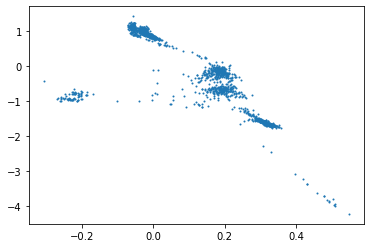

In [29]:
plt.scatter(Mu_Xs, Mu_Ys, s=1)

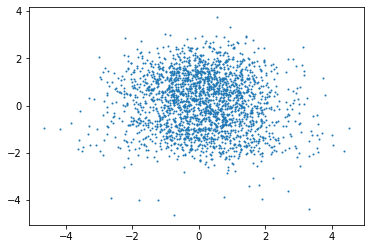

In [30]:
plt.scatter(Latent_Xs, Latent_Ys, s=1)

(array([  7.,   4.,  43., 295., 434., 474., 565., 356.,  87.,   9.]),
 array([-4.6210885 , -3.78545003, -2.94981155, -2.11417308, -1.2785346 ,
        -0.44289613,  0.39274235,  1.22838082,  2.0640193 ,  2.89965777,
         3.73529625]),
 <BarContainer object of 10 artists>)

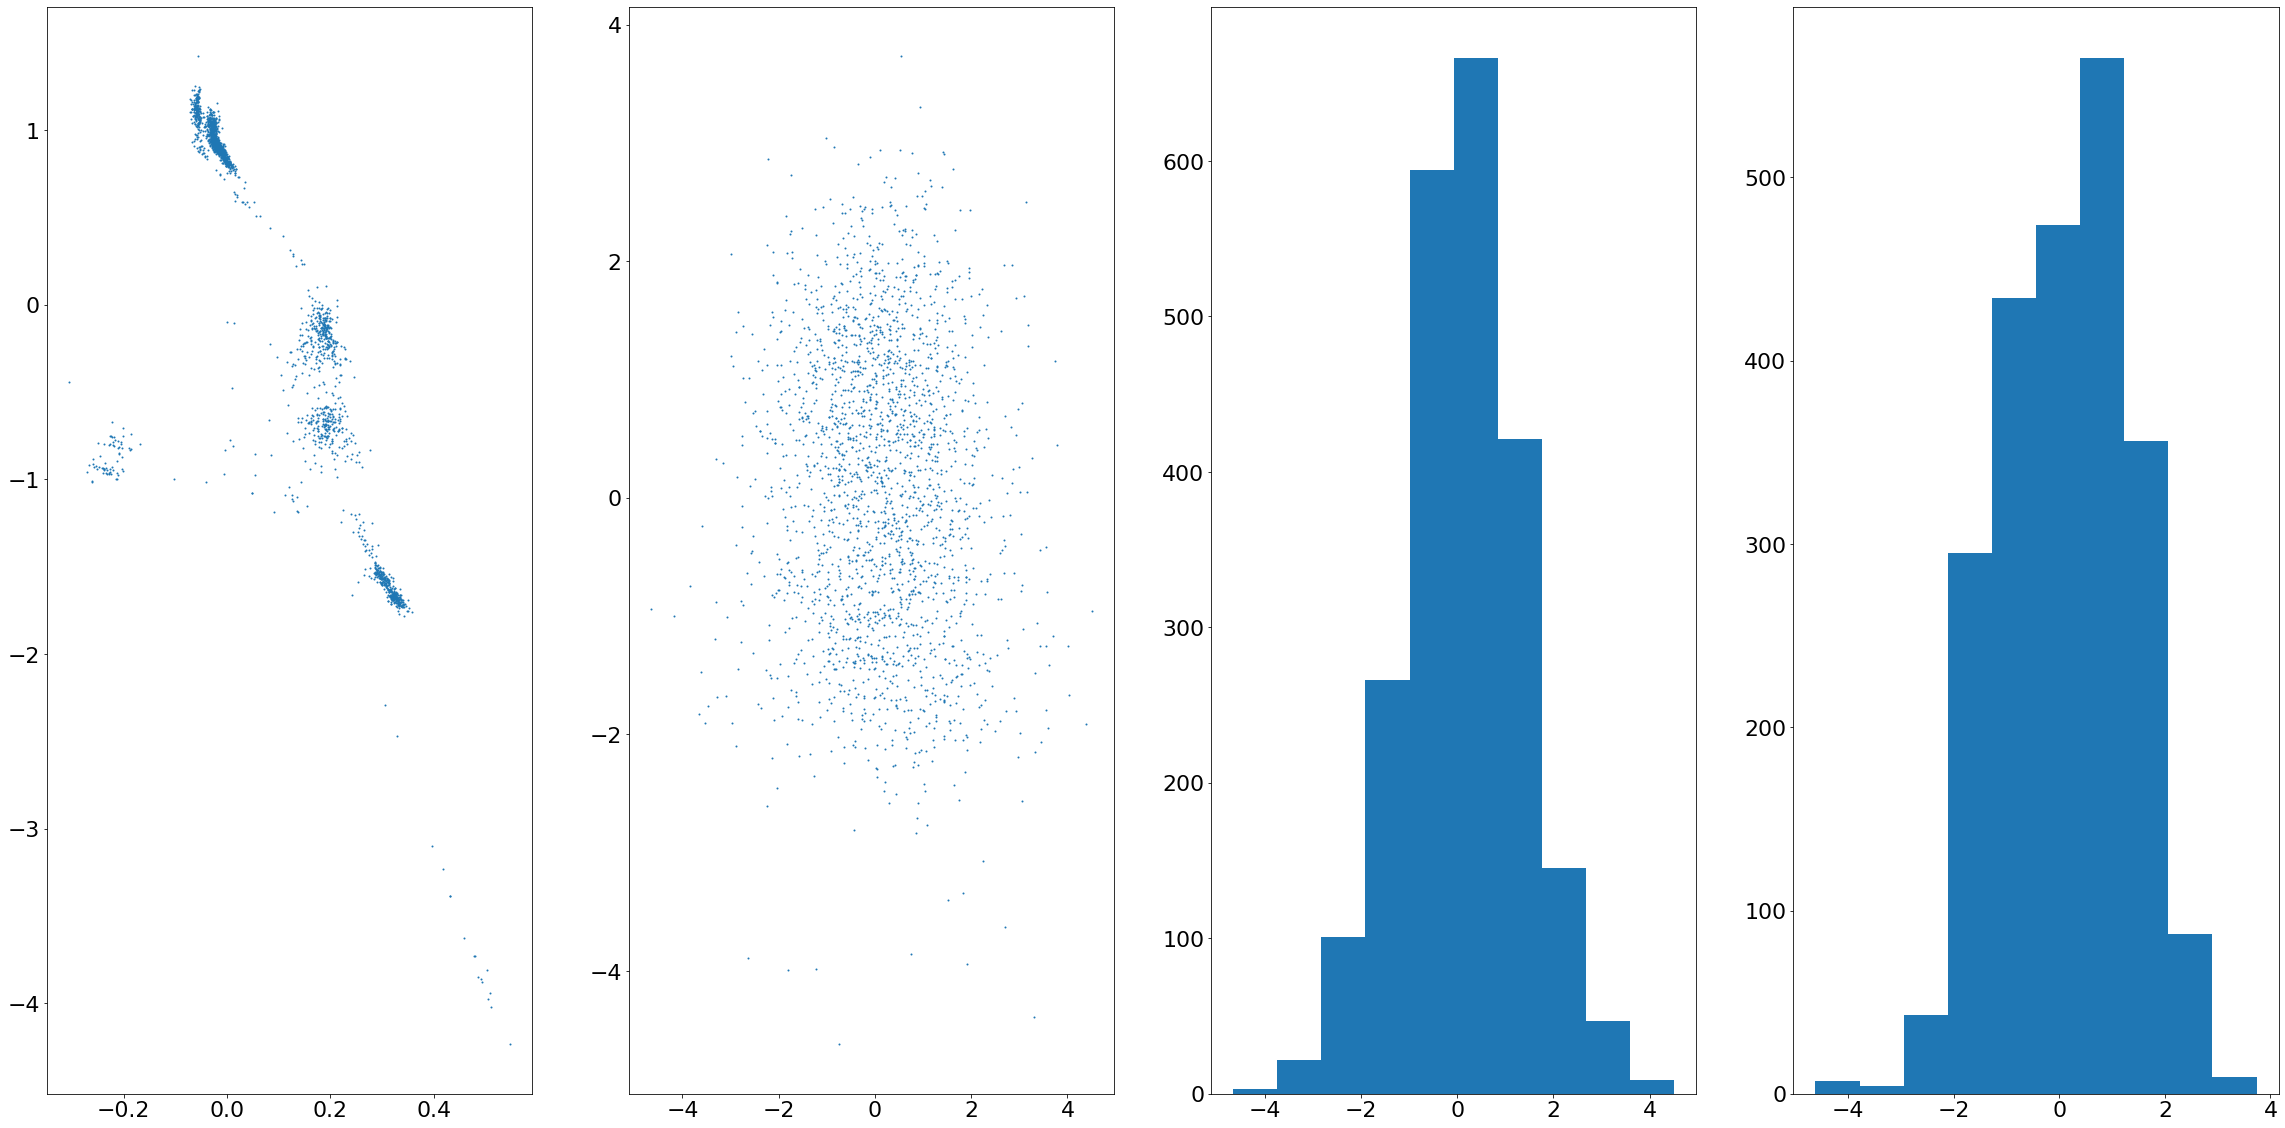

In [31]:
plt.rc('font', size=12)
matplotlib.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(40, 20))
ax = fig.subplots(1, 4)
ax[0].scatter(Mu_Xs, Mu_Ys, s=1)
ax[1].scatter(Latent_Xs, Latent_Ys, s=1)
ax[2].hist(Latent_Xs)
ax[3].hist(Latent_Ys)

In [32]:
print(f"Var Latent X: {np.var(Latent_Xs):.4f}")
print(f"Var Latent Y: {np.var(Latent_Ys):.4f}")

print(f"Var Mu X: {np.var(Mu_Xs):.4f}")
print(f"Var Mu Y: {np.var(Mu_Ys):.4f}")

Var Latent X: 1.5574
Var Latent Y: 1.5001
Var Mu X: 0.0216
Var Mu Y: 1.0947


In [33]:
np.cov(Latent_Xs, Latent_Ys)

array([[ 1.55812804, -0.11733192],
       [-0.11733192,  1.50077765]])

## generate new sequences

In [34]:
generated_seqs = [None, None, None]
generated_seqs_new = [None, None, None]

In [35]:
# generate random latent variables
p = torch.distributions.Normal(
    torch.zeros(FC_LATENT_DIM, device=VAE.device), 
    torch.ones(FC_LATENT_DIM, device=VAE.device))
Zs = p.sample(sample_shape=torch.Size([FC_SAMPLES])).to(VAE.device)
Zs = Zs @ torch.tensor(np.cov(Latent_Xs, Latent_Ys)).to(VAE.device).float()

### lowly antigenic

In [36]:
j = 0

In [37]:
seqs = get_seq_from_latent_FcVAE(VAE, Zs, j)

seqs_2 = {}
for seq, cnt in seqs.items():
    if seq not in VAE.ds.viral_seqs:
        seqs_2.update({seq: cnt})
        
write_seqs_to_fasta(seqs_2, f".{os.sep}data{os.sep}spike_protein_sequences{os.sep}{FC_GEN_FILENAME}_high.fasta")
        
print(f"Generated: {len(seqs)} New: {len(seqs_2)}")

generated_seqs[j] = seqs
generated_seqs_new[j] = seqs_2

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.43it/s]

Generated: 35 New: 27


### intermediate antigenic

In [38]:
j = 1

In [39]:
generated_seqs[j] = get_seq_from_latent_FcVAE(VAE, Zs, j)

generated_seqs_new[j] = {}
for seq, cnt in generated_seqs[j].items():
    if seq not in VAE.ds.viral_seqs:
        generated_seqs_new[j].update({seq: cnt})
        
write_seqs_to_fasta(generated_seqs_new[j], f".{os.sep}data{os.sep}spike_protein_sequences{os.sep}{FC_GEN_FILENAME}_high.fasta")
        
print(f"Generated: {len(generated_seqs[j])} New: {len(generated_seqs_new[j])}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.56it/s]

Generated: 38 New: 28


### highly antigenic

In [40]:
j = 2

In [41]:
generated_seqs[j] = get_seq_from_latent_FcVAE(VAE, Zs, j)

generated_seqs_new[j] = {}
for seq, cnt in generated_seqs[j].items():
    if seq not in VAE.ds.viral_seqs:
        generated_seqs_new[j].update({seq: cnt})
        
write_seqs_to_fasta(generated_seqs_new[j], f".{os.sep}data{os.sep}spike_protein_sequences{os.sep}{FC_GEN_FILENAME}_high.fasta")
        
print(f"Generated: {len(generated_seqs[j])} New: {len(generated_seqs_new[j])}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.58it/s]

Generated: 32 New: 24


### evaluate antigenicity

#### with ImmunoBERT

In [42]:
for j in range(3):
    for seq in tqdm(generated_seqs_new[j].keys()):             
        IB_seq_presentation[seq], IB_seq_scores[seq] = score_seq_IB(model, seq,  MHC_list, IB_peptide_scores)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [02:27<00:00,  6.13s/it]


C:\Users\s2118339\anaconda3\envs\VC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\s2118339\anaconda3\envs\VC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\s2118339\anaconda3\envs\VC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

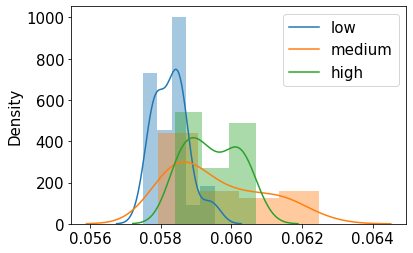

In [51]:
matplotlib.rcParams.update({'font.size': 15})

for j in range(3):
    sns.distplot([IB_seq_scores[seq] for seq in generated_seqs_new[j].keys()])

plt.legend(labels=["low","medium", "high"])

#### with netMHCpan

In [43]:
missing = []
for j in range(3):
    for seq in tqdm(list(generated_seqs_new[j].keys())):
        seq = seq.replace("-", "")
        for position in range(len(seq)-9):
            if seq[position:(position+9)] not in nMp_peptide_scores:
                missing.append(seq[position:(position+9)])
                
file = open(f"{NMP_FOLDER_1}{os.sep}missing.pep", "w")
for peptide in missing:
      file.writelines([peptide, "\n"])
file.close()

for mhc_name in MHC_list:
    # print(mhc_name)
    mhc_name_2 = mhc_name.replace(":", "").replace("HLA-", "")
    
    print(f"./netMHCpan -p {NMP_FOLDER_2}/missing.pep -a {mhc_name} > {NMP_FOLDER_2}/missing_{mhc_name_2}.pep.out")
    print("\n")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 2727.78it/s]

./netMHCpan -p ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/missing.pep -a HLA-A01:01 > ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/missing_A0101.pep.out


./netMHCpan -p ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/missing.pep -a HLA-A02:01 > ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/missing_A0201.pep.out


./netMHCpan -p ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/missing.pep -a HLA-A03:01 > ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/missing_A0301.pep.out


./netMHCpan -p ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/missing.pep -a HLA-A24:02 > ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/missing_A2402.pep.out


./netMHCpan -p ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/missing.pep -a HLA-A26:01 > ~/win/Documents/2022H1/Group_project/CovidProject/netMHCpan/missing_A2601.pep.out


./netMHCpan -p ~/win/Documents/2022H1/Group_project/CovidProject/

In [46]:
nMp_peptide_scores.update(eval_peptides_nMp("missing", MHC_list))

HLA-A01:01
peptide: NKSWMESER   rank_el: 64.762
peptide: KSWMESERV   rank_el: 9.726
peptide: SWMESERVY   rank_el: 4.322
peptide: WMESERVYS   rank_el: 19.716
peptide: MESERVYSS   rank_el: 32.864
peptide: ESERVYSSA   rank_el: 3.886
peptide: SERVYSSAN   rank_el: 83.125
peptide: ERVYSSANN   rank_el: 97.857
peptide: SNVTWFHAH   rank_el: 11.051
peptide: NVTWFHAHI   rank_el: 22.544
peptide: VTWFHAHIS   rank_el: 15.396
peptide: TWFHAHISG   rank_el: 81.25
peptide: WFHAHISGT   rank_el: 71.923
peptide: FHAHISGTN   rank_el: 68.333
peptide: HAHISGTNG   rank_el: 58.2
peptide: AHISGTNGT   rank_el: 51.774
peptide: YSKHTPINI   rank_el: 6.388
peptide: SKHTPINIV   rank_el: 37.933
peptide: KHTPINIVR   rank_el: 20.817
peptide: HTPINIVRD   rank_el: 43.636
peptide: TPINIVRDL   rank_el: 31.625
peptide: PINIVRDLP   rank_el: 60.714
peptide: INIVRDLPQ   rank_el: 74.231
peptide: NIVRDLPQG   rank_el: 70.0
peptide: NKSWMESGR   rank_el: 70.769
peptide: KSWMESGRV   rank_el: 13.078
peptide: SWMESGRVY   rank_el: 3.794


peptide: LTTRTQPPA   rank_el: 23.769
peptide: TTRTQPPAY   rank_el: 4.075
peptide: TRTQPPAYT   rank_el: 29.294
peptide: RTQPPAYTN   rank_el: 22.5
peptide: TQPPAYTNS   rank_el: 34.455
peptide: QPPAYTNSF   rank_el: 0.401
peptide: GSTPCNGVA   rank_el: 38.286
peptide: STPCNGVAG   rank_el: 44.0
peptide: TPCNGVAGF   rank_el: 0.968


HLA-B08:01
peptide: NKSWMESER   rank_el: 62.955
peptide: KSWMESERV   rank_el: 36.724
peptide: SWMESERVY   rank_el: 17.956
peptide: WMESERVYS   rank_el: 44.643
peptide: MESERVYSS   rank_el: 8.925
peptide: ESERVYSSA   rank_el: 19.717
peptide: SERVYSSAN   rank_el: 48.5
peptide: ERVYSSANN   rank_el: 88.571
peptide: SNVTWFHAH   rank_el: 17.228
peptide: NVTWFHAHI   rank_el: 14.779
peptide: VTWFHAHIS   rank_el: 41.778
peptide: TWFHAHISG   rank_el: 31.093
peptide: WFHAHISGT   rank_el: 15.505
peptide: FHAHISGTN   rank_el: 79.0
peptide: HAHISGTNG   rank_el: 36.034
peptide: AHISGTNGT   rank_el: 48.4
peptide: YSKHTPINI   rank_el: 2.802
peptide: SKHTPINIV   rank_el: 7.552
pept

peptide: NVTWFHAII   rank_el: 49.0
peptide: VTWFHAIIS   rank_el: 39.1
peptide: TWFHAIISG   rank_el: 32.75
peptide: WFHAIISGT   rank_el: 69.167
peptide: FHAIISGTN   rank_el: 76.667
peptide: HAIISGTNG   rank_el: 30.792
peptide: AIISGTNGT   rank_el: 17.988
peptide: IISGTNGTK   rank_el: 15.478
peptide: VLYNSAPFF   rank_el: 0.282
peptide: LYNSAPFFT   rank_el: 69.167
peptide: YNSAPFFTF   rank_el: 2.629
peptide: NSAPFFTFK   rank_el: 19.848
peptide: SAPFFTFKC   rank_el: 43.143
peptide: FPLQSYGFR   rank_el: 52.222
peptide: PLQSYGFRP   rank_el: 78.333
peptide: LQSYGFRPT   rank_el: 13.41
peptide: QSYGFRPTY   rank_el: 0.155
peptide: FRPTYGVGY   rank_el: 5.968
peptide: RPTYGVGYQ   rank_el: 55.0
peptide: NKSWMESGR   rank_el: 63.75
peptide: KSWMESGRV   rank_el: 17.865
peptide: SWMESGRVY   rank_el: 1.0
peptide: WMESGRVYS   rank_el: 39.3
peptide: MESGRVYSS   rank_el: 37.25
peptide: ESGRVYSSA   rank_el: 41.25
peptide: SGRVYSSAN   rank_el: 51.667
peptide: GRVYSSANN   rank_el: 83.333
peptide: VLYNSAPFF   

In [47]:
for j in range(3):
    for seq in tqdm(generated_seqs_new[j].keys()):
        nMp_seq_scores[seq] = score_seq_nMp(seq, MHC_list, nMp_peptide_scores)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1230.63it/s]


C:\Users\s2118339\anaconda3\envs\VC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\s2118339\anaconda3\envs\VC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\s2118339\anaconda3\envs\VC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

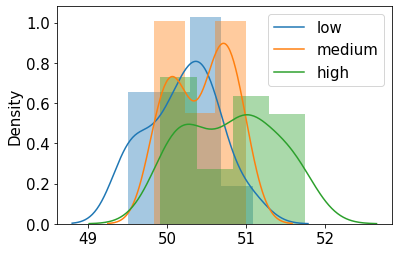

In [52]:
matplotlib.rcParams.update({'font.size': 15})

for j in range(3):
    sns.distplot([nMp_seq_scores[seq] for seq in generated_seqs_new[j].keys()])

plt.legend(labels=["low","medium", "high"])